<a href="https://colab.research.google.com/github/bogatovam/ml-course-hse/blob/master/ML_LAB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть №1: визуализация, предобработка, классификация

## 1. Описание задачи и данных

Дан датасет бронирований отеля. Необходимо предсказать, будет отменено то или иное бронирование или нет.

In [3]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd            
import seaborn as sns           
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [4]:
sns.set(style="darkgrid")

Загрузка данных

In [5]:
url = "https://github.com/bogatovam/ml-course-hse/raw/master/hotel_bookings.csv"
data_raw = pd.read_csv(url)

Датасет содержит 32 признака. Каждый из них подробно описан на странице датасета (https://www.sciencedirect.com/science/article/pii/S2352340918315191). Требуется предсказать бинарный признак is_canceled - указывающий, было ли бронирование отменено (1) или нет (0).

Преобразуем столбец `reservation_status_date` с типом дата в два числовых признака, разделив его соответственно на год, и номер дня, когда было сделано последнее бронирование.

In [6]:
data_raw['reservation_status_year'] = pd.DatetimeIndex(data_raw['reservation_status_date']).year
data_raw['reservation_status_day'] = pd.DatetimeIndex(data_raw['reservation_status_date']).dayofyear
del data_raw['reservation_status_date']

Изменим тип у всех категориальных признаков

In [7]:
for feature in data_raw.columns:
  if data_raw[feature].dtype == object:
    data_raw[feature] = data_raw[feature].astype('category')

In [8]:
country_codes = dict(zip(data_raw['country'].unique().tolist(), data_raw['country'].unique().codes.tolist()))

In [9]:
data_raw['country'] = data_raw['country'].cat.codes

In [10]:
data_raw.loc[data_raw.country ==-1, 'country'] = np.nan

Информация о виде каждого признака:

In [11]:
data_describe = data_raw.describe(include = ['category'])

numerical_features = [f for f in data_raw.columns if data_raw[f].dtype.name is not 'category']
categorical_features = [f for f in data_raw.columns if data_raw[f].dtype.name is 'category']
binary_columns    = [f for f in categorical_features if data_describe[f]['unique'] == 2]
nonbinary_columns = [f for f in categorical_features if data_describe[f]['unique'] > 2]

In [12]:
numerical_features

['is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'country',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_year',
 'reservation_status_day']

In [13]:
binary_columns

['hotel']

In [14]:
nonbinary_columns

['arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status']

## 2. Визуализация данных

In [13]:
 data_raw.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_year,reservation_status_day
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,118902.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,92.990076,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016.093743,177.495376
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,44.676327,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,0.715306,102.513594
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2014.000000,1.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016.000000,89.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,81.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016.000000,181.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,135.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017.000000,264.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,176.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017.000000,366.000000


In [14]:
 data_raw.describe(include = ['category'])

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,8,5,10,12,3,4,3
top,City Hotel,August,BB,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79330,13877,92310,56477,97870,85994,74053,104641,89613,75166


Выборка является несбалансированной: экземпляров бронирований без отмены быльше, чем с отменой

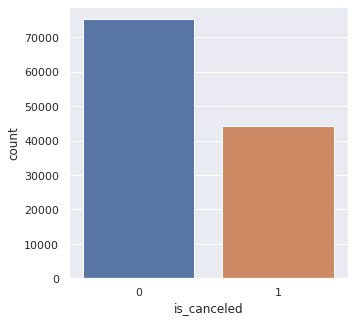

In [15]:
plt.figure(figsize = (5, 5))

sns.countplot(x='is_canceled', data=data_raw)
pass

Видна зависимость между отменой бронирования и временем до заселения, за которое было произведено бронирование. То есть, при рассмотрении довольно большого значения lead_time, бронирования отменяются чаще, нежели чем сохраняются.

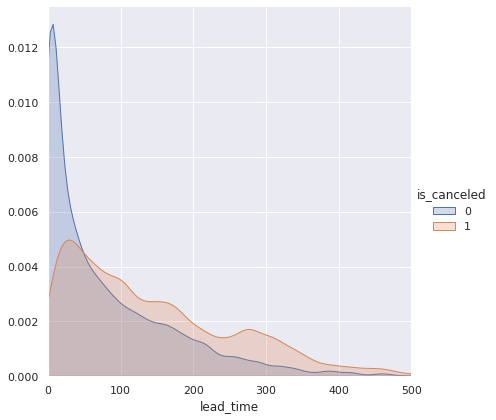

In [16]:
(sns.FacetGrid(data_raw, hue = 'is_canceled',
             height = 6,
             xlim = (0,500))
    .map(sns.kdeplot, 'lead_time', shade = True)
    .add_legend())
pass

Если рассмотреть зависимость отказов от страны, из которой сделано бронирование, то можно сказать, что в определенном диапазоне стран отмены происходят довольно часто.

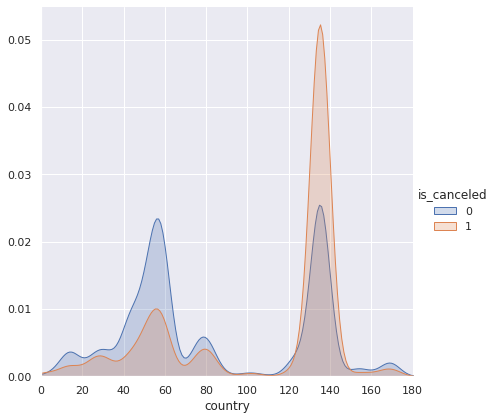

In [17]:
(sns.FacetGrid(data_raw, hue = 'is_canceled',
             height = 6,
             xlim = (0,180))
    .map(sns.kdeplot, 'country', shade = True)
    .add_legend())
pass

Результаты графика ниже интуитивно понятны: среди постоянных гостей меньше отмененных бронирований

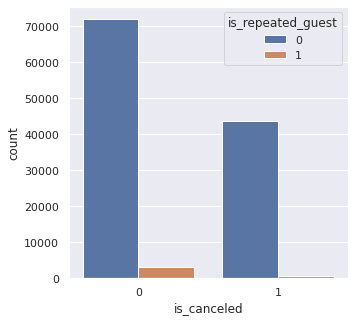

In [18]:
plt.figure(figsize = (5, 5))

sns.countplot(x='is_canceled', hue='is_repeated_guest', data=data_raw)
pass

Интересная зависимость отмен от количества времени, проведенного в ожидании подтверждения бронировния от отеля: прежде чем отменить бронь, люди ждут либо не долго( по сравнению с 400-мя днями) либо очень долго. В любом случае, чем больше времени проведенного в ожиданее, тем вероятней отмена.

<Figure size 1080x1080 with 0 Axes>

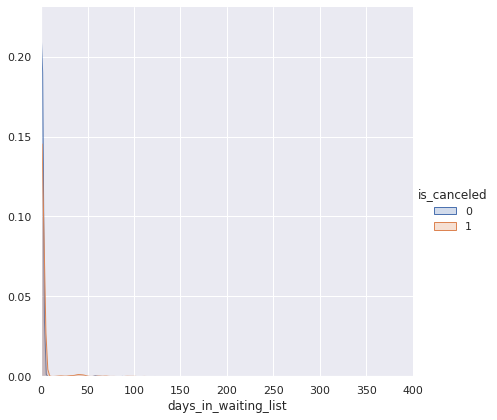

In [19]:
plt.figure(figsize = (15, 15))
(sns.FacetGrid(data_raw, hue = 'is_canceled',
             height = 6,
             xlim = (0,400))
    .map(sns.kdeplot, 'days_in_waiting_list', shade = True)
    .add_legend())
pass

Ниже представлена зависимость между временем ожидания и общим количеством заказов от клиента. Видно, что клиенты с далеко не первым бронированием практически всегда обслуживаются в первый день. А клиенты, у которых количество бронирований до 10 и которые ожидают более одного дня в основном отказываются от бронирования. 

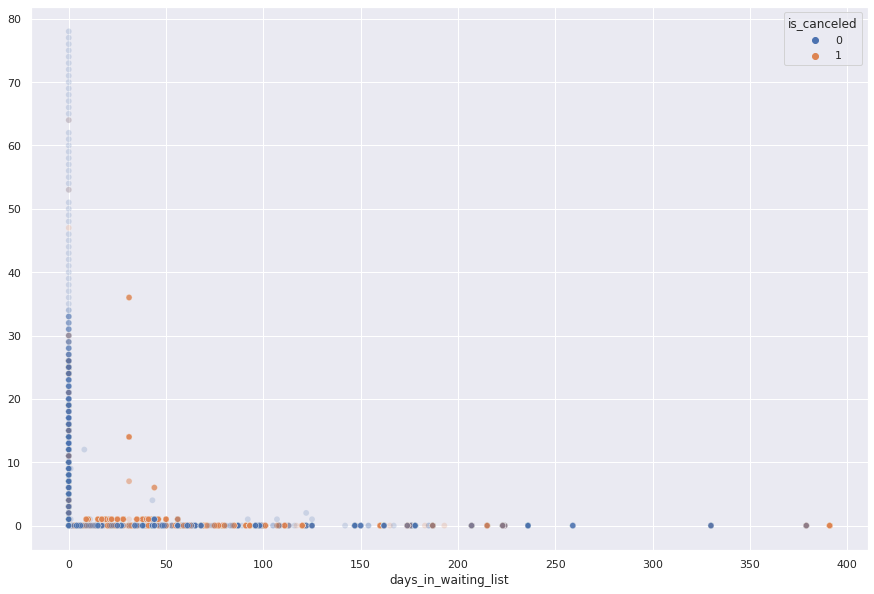

In [20]:
plt.figure(figsize = (15, 10))

all_boocking_count = data_raw['previous_cancellations'] + data_raw['previous_bookings_not_canceled']
total_time= data_raw['stays_in_weekend_nights'] + data_raw['stays_in_week_nights']
people_count = data_raw['adults'] + data_raw['children']+ data_raw['babies']

sns.scatterplot(x='days_in_waiting_list', y=all_boocking_count, hue='is_canceled', data=data_raw, alpha=0.2)
pass

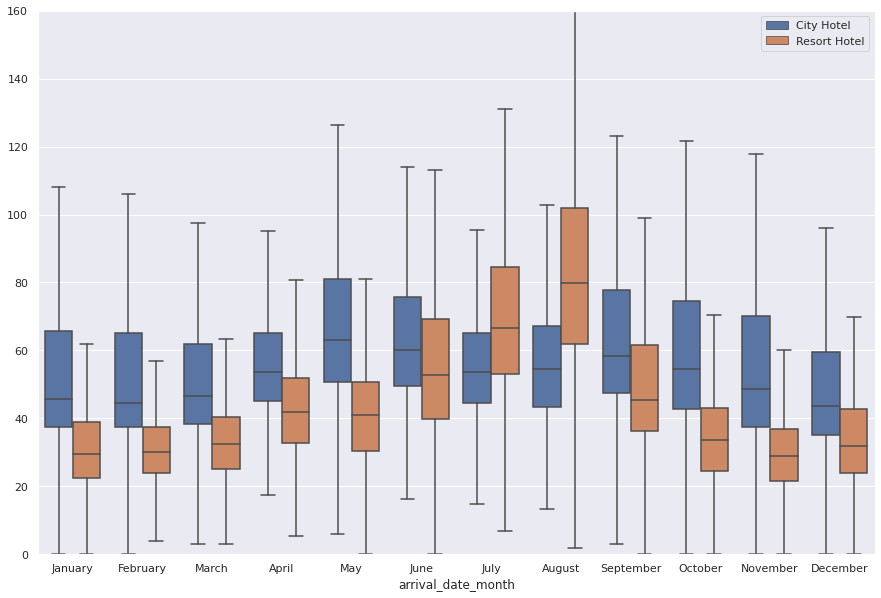

In [21]:
# Calculate price per night
full_data_guests = data_raw.loc[data_raw["is_canceled"] == 0] 

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

room_prices = full_data_guests.sort_values("arrival_date_month")

room_prices['arrival_date_month'] =pd.Categorical(room_prices["arrival_date_month"], categories=ordered_months, ordered=True)
adr_pp = room_prices["adr"] / (room_prices["adults"] + room_prices["children"])

plt.figure(figsize=(15, 10))
sns.boxplot(x="arrival_date_month",
            y=adr_pp,
            hue="hotel",
            data=room_prices,
            fliersize=0)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

Из графика ниже видно, что туристические агенства популярны круглый год, однако в августе через них поступает больше всего бронирований.

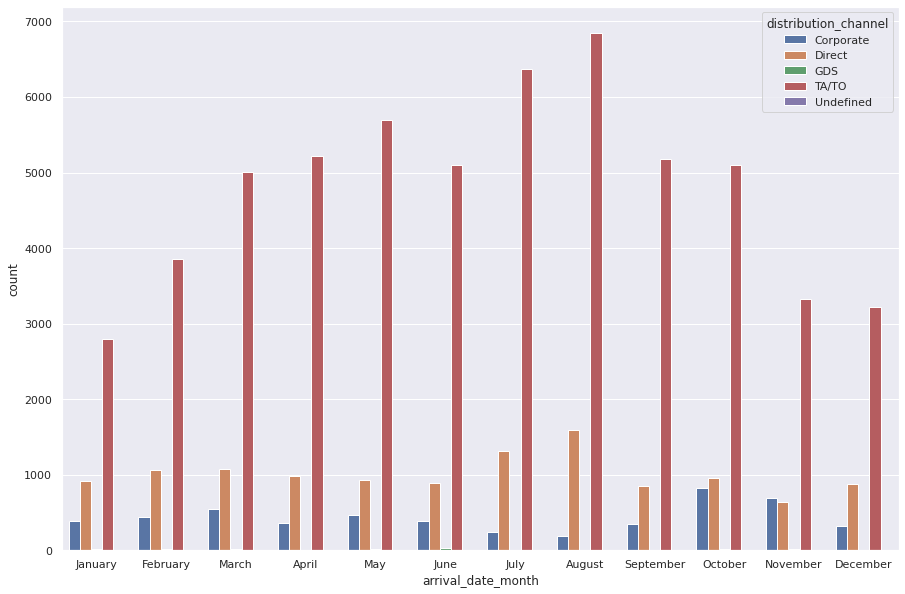

In [22]:
plt.figure(figsize=(15, 10))
sns.countplot(x=room_prices['arrival_date_month'], hue = 'distribution_channel', data=full_data_guests)
pass

Ниже зависимость от 'lead_time' и количеством дней, на которое бронируют отель. Видно, что курортные отели чаще всего бронируют на  6-7 дней, реже 13-14, и такие бронирования довольно редко отменяются.

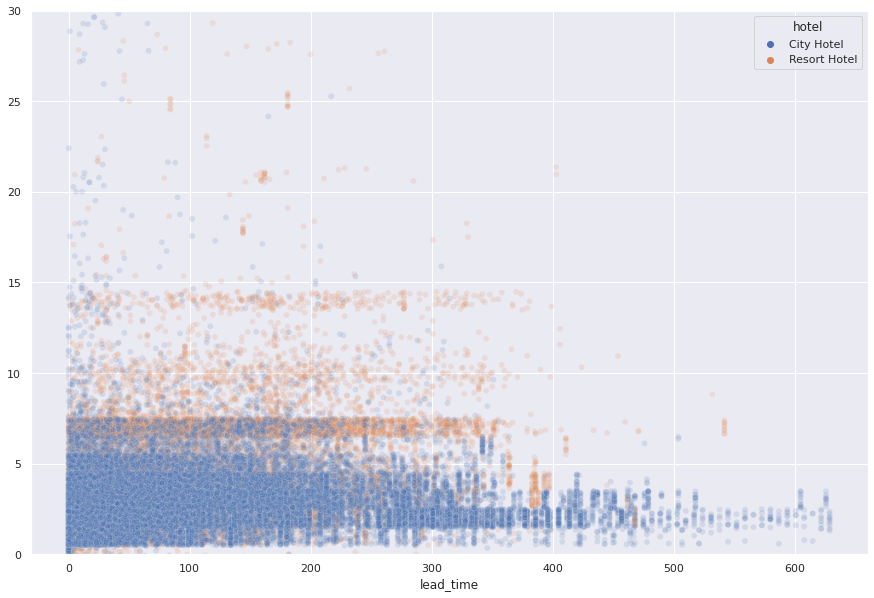

In [23]:
plt.figure(figsize=(15, 10))

random_subset = np.random.choice(np.arange(data_raw.shape[0]), size=50000, replace=False)
time_rnd = total_time + np.random.rand(data_raw.shape[0]) - .5
sns.scatterplot(x='lead_time', y=time_rnd, hue='hotel', data=data_raw.iloc[random_subset] , alpha=0.15)

plt.ylim(0, 30)
pass

Для городского отеля наиболее популярной явлется комната типа А, и скорее всего гости возвращаются и заселяются в этот же тип комнаты только благодаря ее популярности.

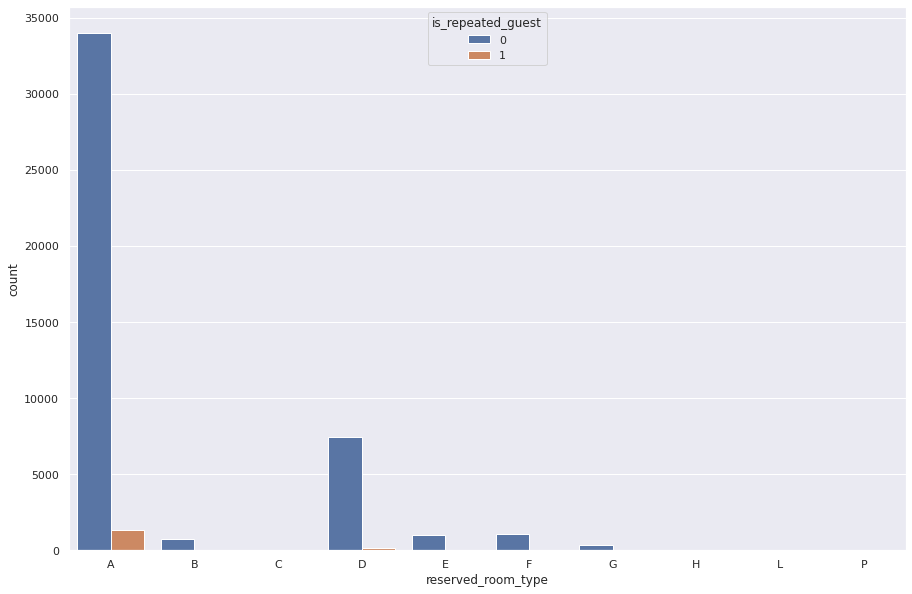

In [24]:
plt.figure(figsize=(15, 10))
city_guests = full_data_guests.loc[full_data_guests["hotel"] == "City Hotel"]
sns.countplot(x=city_guests['reserved_room_type'], hue = 'is_repeated_guest', data=city_guests)
pass

А вот для курортного отеля также популярны комнаты типа D и E.

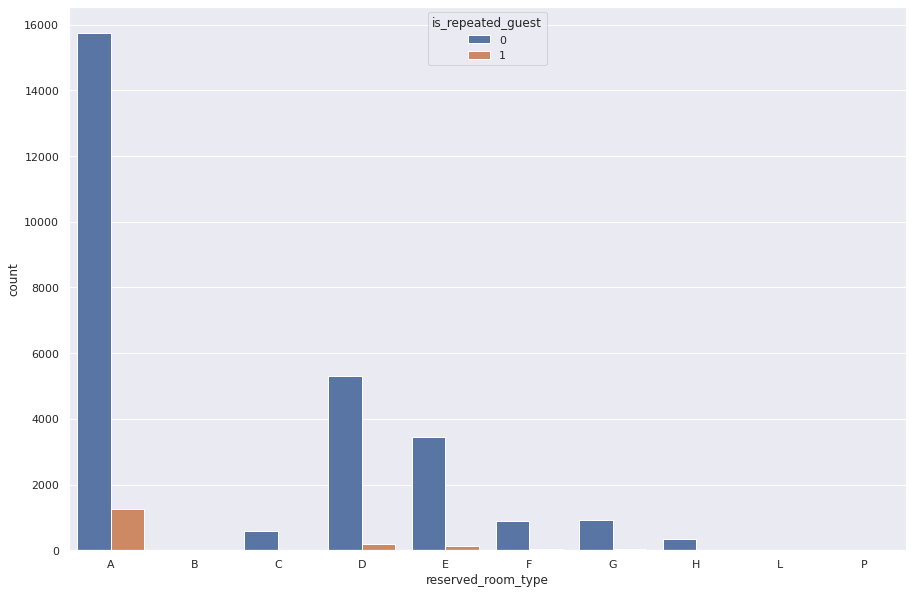

In [25]:
plt.figure(figsize=(15, 10))
resort_guests = full_data_guests.loc[full_data_guests["hotel"] == "Resort Hotel"]
sns.countplot(x=resort_guests['reserved_room_type'], hue = 'is_repeated_guest', data=resort_guests)
pass

## 3. Препроцессинг

### 3.1 Корреляция

In [15]:
from sklearn.preprocessing import LabelEncoder
corr_data = data_raw.copy()

le = LabelEncoder()

corr_data['hotel'] = le.fit_transform(corr_data['hotel'])
corr_data['arrival_date_month'] = le.fit_transform(corr_data['arrival_date_month'])
corr_data['meal'] = le.fit_transform(corr_data['meal'])
corr_data['distribution_channel'] = le.fit_transform(corr_data['distribution_channel'])
corr_data['reserved_room_type'] = le.fit_transform(corr_data['reserved_room_type'])
corr_data['assigned_room_type'] = le.fit_transform(corr_data['assigned_room_type'])
corr_data['customer_type'] = le.fit_transform(corr_data['customer_type'])
corr_data['reservation_status'] = le.fit_transform(corr_data['reservation_status'])
corr_data['market_segment'] = le.fit_transform(corr_data['market_segment'])
corr_data['deposit_type'] = le.fit_transform(corr_data['deposit_type'])

In [16]:
corr_mat = corr_data.corr()

In [17]:
corr_mat["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
deposit_type                      0.468634
lead_time                         0.293123
country                           0.270254
distribution_channel              0.167600
previous_cancellations            0.110133
adults                            0.060017
market_segment                    0.059338
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
arrival_date_month               -0.001491
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
meal                             -0.017678
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
reserved_room_type               -0.061282
customer_type                    -0.068140
reservation

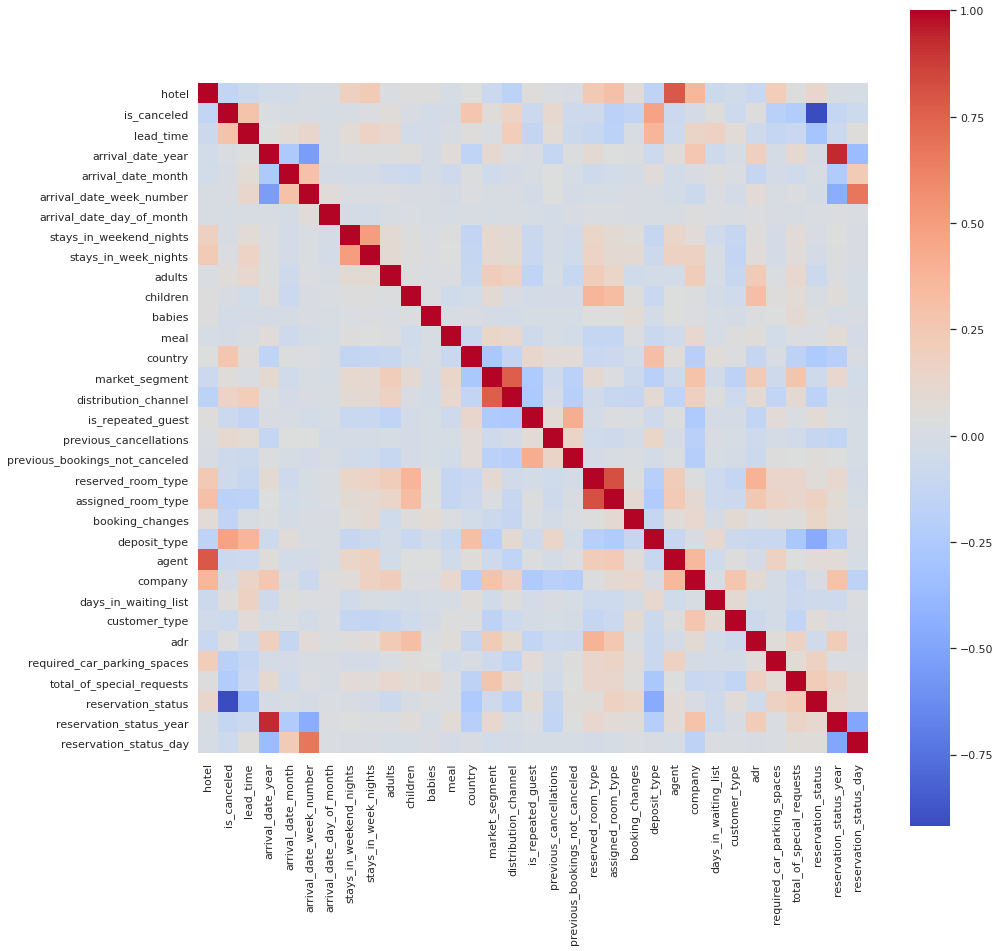

In [18]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Исключим из датасета признаки с слишком низким коэффициентом корреляции: их влияние на предсказания несущественно: 

  * `arrival_date_week_number`          
  * `children`                          
  * `arrival_date_month`               
  * `stays_in_weekend_nights`          
  * `arrival_date_day_of_month`

In [19]:
data_raw = data_raw.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'children','arrival_date_day_of_month'], axis = 1)

### 3.2. Удаление пропущенных значений

Заменим пропущенные значения в номинальных признаках NaN для корректного подсчета количества пропущенных значений.

In [20]:
data_raw.loc[data_raw.meal == 'Undefined', 'meal'] = np.nan
data_raw.loc[data_raw.market_segment == 'Undefined', 'market_segment'] = np.nan
data_raw.loc[data_raw.distribution_channel == 'Undefined', 'distribution_channel'] = np.nan

In [21]:
print("# of NaN in each columns:", data_raw.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
stays_in_week_nights                   0
adults                                 0
babies                                 0
meal                                1169
country                              488
market_segment                         2
distribution_channel                   5
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces    

In [22]:
for feature in data_raw.columns:
  mv =  data_raw[feature].isnull().sum()
  if mv > 0:
    p = mv / len(data_raw[feature]) * 100
    print('{}\t\t\t->\t{}\t%'.format(feature, p))


meal			->	0.9791439819080325	%
country			->	0.40874445095904177	%
market_segment			->	0.0016751821760616465	%
distribution_channel			->	0.004187955440154116	%
agent			->	13.686238378423655	%
company			->	94.30689337465449	%


*   `company`- по большей части значения отсутствуют. В таком случае замена пропущенных значений средним или медианой не придаст точности модели. Поэтому признак `company` **удаляется**.
*   Значения признаков, у которых количество пропущенных значений меньше, чем один процент, заменим медианой/модой.
*   Признак `agent` удаляем, потому что он имеет достаточно большое количество значений и его влияние на предсказания есть, но оно не достаточно большое.


In [23]:
data_raw = data_raw.drop(columns = ['company', 'agent'], axis = 1)

In [24]:
data_raw['meal'].fillna(data_raw['meal'].mode().iloc[0], inplace=True)
data_raw['market_segment'].fillna(data_raw['market_segment'].mode().iloc[0], inplace=True)
data_raw['distribution_channel'].fillna(data_raw['distribution_channel'].mode().iloc[0], inplace=True)

In [25]:
data_raw['country'].fillna(data_raw['country'].median(axis = 0), axis=0 , inplace=True)

In [26]:
print("# of NaN in each columns:", data_raw.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
stays_in_week_nights              0
adults                            0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_year           0
reservation_status_day            0
dtype: int64


### 3.3. Трансформация категориальных признаков


In [27]:
data_raw.dtypes

hotel                             category
is_canceled                          int64
lead_time                            int64
arrival_date_year                    int64
stays_in_week_nights                 int64
adults                               int64
babies                               int64
meal                              category
country                            float64
market_segment                    category
distribution_channel              category
is_repeated_guest                    int64
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                category
assigned_room_type                category
booking_changes                      int64
deposit_type                      category
days_in_waiting_list                 int64
customer_type                     category
adr                                float64
required_car_parking_spaces          int64
total_of_special_requests            int64
reservation

`Resort Hotel` → 0, `City Hotel`→ 1

In [28]:
data_raw['hotel'] = pd.factorize(data_raw['hotel'])[0]

In [29]:
data_raw = pd.get_dummies(data = data_raw, columns = ['meal', 'market_segment', 'distribution_channel', 'reserved_room_type',
                                                     'assigned_room_type', 'deposit_type', 'customer_type'])

Также удаляем `reservation_status`- он в некотором смысле копирует предсказываемый признак. 

In [30]:
data_raw = data_raw.drop(columns = ['distribution_channel_Undefined', 'market_segment_Undefined', 'meal_Undefined', 'reservation_status'], axis = 1)

In [31]:
data_raw.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'stays_in_week_nights', 'adults', 'babies', 'country',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_year',
       'reservation_status_day', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
      

### 3.4. Избавление от выбросов

На некоторых графиках можно заметить явные выбросы. Например ниже: 

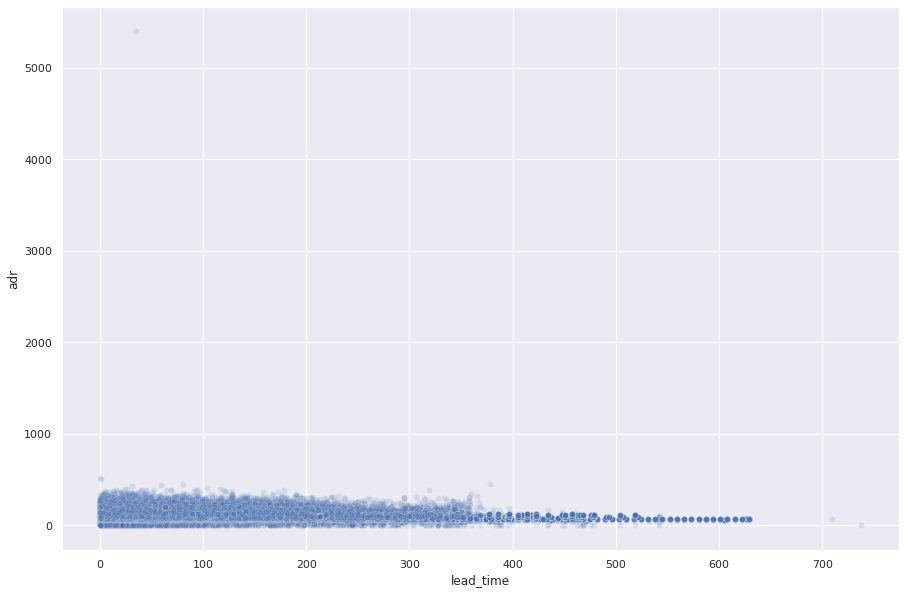

In [32]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x='lead_time', y='adr', data=data_raw, alpha=0.15)

pass

In [33]:
data_raw = data_raw[data_raw['lead_time']<700]
data_raw = data_raw[data_raw['adr']<5000]

### 3.5. Стандартизация

In [34]:
data_stand = (data_raw - data_raw.mean(axis = 0))/data_raw.std(axis = 0)

## 4. Построение и сравнение моделей

In [35]:
from sklearn import metrics as metrics


def METRICS(y_true, y_pred, y_prob, probability=True):
    y_pred = np.around(y_pred, 0)

    acc = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)

    if probability:
      false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_true, y_prob)
      roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    else: 
      roc_auc = -1
      
    return {
        'acc': acc,
        'recall': recall,
        'precision': precision,
        'auc': roc_auc
    }

In [37]:
def ROC(y_true, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_true, y_prob)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [38]:
def CONFUSION(y_test, y_test_predict):
     sns.heatmap(metrics.confusion_matrix(y_test, y_test_predict), annot=True)

In [39]:
def learn_and_test_model(model, params, x_train, y_train, x_test, y_test, grid_search=True, verbose=True, probability=True):
    if grid_search:
      best_params = search_best_params(model, params, x_train, y_train)
    else:
      best_params = params

    learned_model = model(**best_params).fit(x_train, y_train)

    err_train = np.mean(y_train != learned_model.predict(x_train))
    err_test  = np.mean(y_test  != learned_model.predict(x_test))

    if verbose:
      print("\nTrain error:\t{}\nTest error:\t{}\n".format(err_train, err_test))

    y_test_predict = learned_model.predict(x_test)
    if probability:
      y_prob = learned_model.predict_proba(x_test)[:,1]
    else:
      y_prob = []

    model_metrics = METRICS(y_test, y_test_predict, y_prob, probability)
    model_metrics['train_error'] = err_train
    model_metrics['test_error'] = err_test
    
    if verbose:
      print("Metrics:\n")
      print(model_metrics)
      CONFUSION(y_test, y_test_predict)
      if probability:
        ROC(y_test, y_prob)
    return best_params, learned_model, model_metrics

In [40]:
def search_best_params(model, params, x_train, y_train):
    grid = GridSearchCV(model(), params, verbose=10, cv=3)
    grid.fit(x_train, y_train)

    best_cv_err = 1 - grid.best_score_

    print("\nBest CV error\t{}\n".format(best_cv_err))

    print("\nBest parameters:\n")
    best_params = {}
    for param_name in params:
      print("\t", param_name,"\t", getattr(grid.best_estimator_, param_name))
      best_params[param_name] = getattr(grid.best_estimator_, param_name)
    return best_params

### 4.1. Разбиение на выборки

In [36]:
X = data_stand.drop(["is_canceled"], axis=1)
Y = data_raw['is_canceled']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

n_train, n_test

(89540, 29847)

### 4.2. Метод ближайшего соседа

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 48.3min finished



Best CV error	0.1373687812504737


Best parameters:

	 n_neighbors 	 3

Train error:	0.06832700469064105
Test error:	0.13113545749991623

Metrics:

{'acc': 0.8688645425000837, 'recall': 0.7975147505810835, 'precision': 0.84399243140965, 'auc': 0.9125226824320206, 'train_error': 0.06832700469064105, 'test_error': 0.13113545749991623}


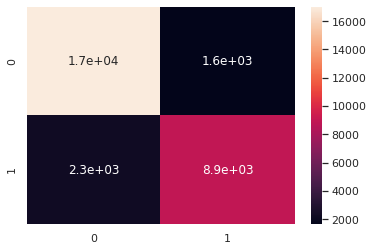

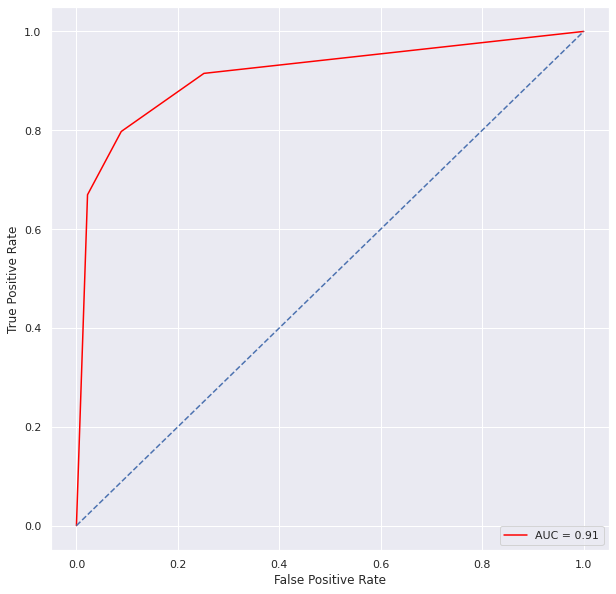

In [ ]:
params = { 
    'n_neighbors': [1, 3, 5, 10, 15, 20, 25]
}

knn_best_params, knn_learned_model, knn_model_metrics = learn_and_test_model(KNeighborsClassifier, params, x_train, y_train, x_test, y_test)

### 4.3. Дерево решений

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   31.0s finished



Best CV error	0.12850122953112386


Best parameters:

	 min_samples_split 	 2
	 max_depth 	 14

Train error:	0.1046571364753183
Test error:	0.12818708747947868

Metrics:

{'acc': 0.8718129125205213, 'recall': 0.796263186125514, 'precision': 0.8520183661756265, 'auc': 0.9342962985503642, 'train_error': 0.1046571364753183, 'test_error': 0.12818708747947868}


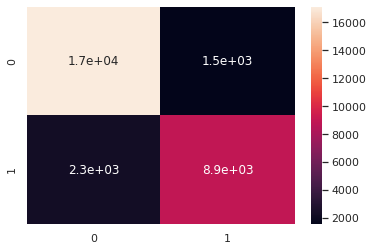

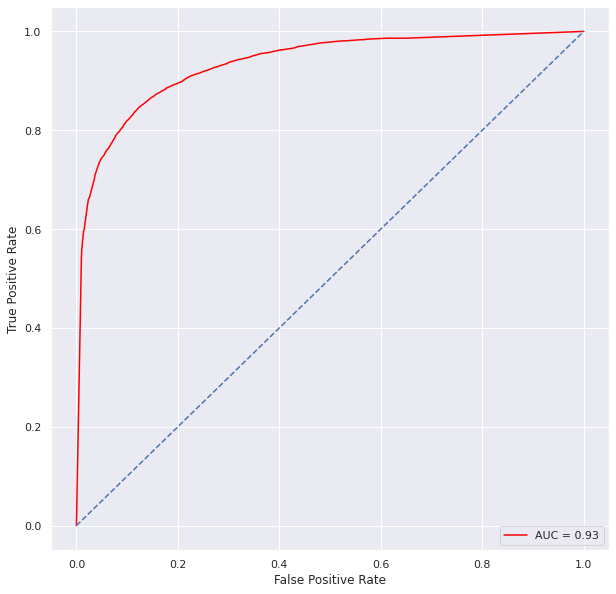

In [ ]:
params = { 
    'min_samples_split': [2, 3, 4],
    'max_depth' : list(range(5, 15))
}

tree_best_params, tree_learned_model, tree_model_metrics = learn_and_test_model(DecisionTreeClassifier, params, x_train, y_train, x_test, y_test)

### 4.4. Random Forest

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 20.6min finished



Best CV error	0.1901161566135504


Best parameters:

	 n_estimators 	 200
	 max_depth 	 8
	 min_samples_split 	 2

Train error:	0.1928746928746929
Test error:	0.19747378295976145

Metrics:

{'acc': 0.8025262170402385, 'recall': 0.4874843554443054, 'precision': 0.9713216957605985, 'auc': 0.9214609434559934, 'train_error': 0.1928746928746929, 'test_error': 0.19747378295976145}


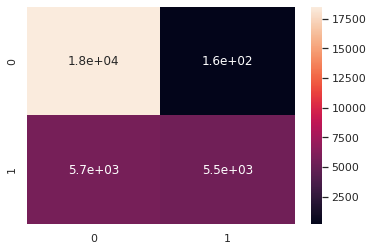

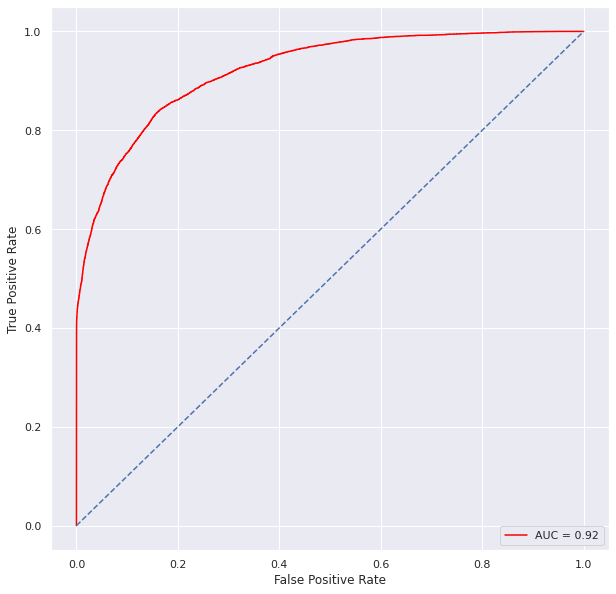

In [ ]:
params = { 
    'n_estimators': [200, 500, 1000],
    'max_depth' : [4, 6, 8],
    'min_samples_split': [2, 3, 4],
}

forest_best_params, forest_learned_model,  forest_model_metrics = learn_and_test_model(RandomForestClassifier, params, x_train, y_train, x_test, y_test)

### 4.5. AdaBoost

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.5min finished



Best CV error	0.14441589892783124


Best parameters:

	 n_estimators 	 1000

Train error:	0.1427741791378155
Test error:	0.14597782021643715

Metrics:

{'acc': 0.8540221797835629, 'recall': 0.7319864115859109, 'precision': 0.8576516183094166, 'auc': 0.9269320263977993, 'train_error': 0.1427741791378155, 'test_error': 0.14597782021643715}


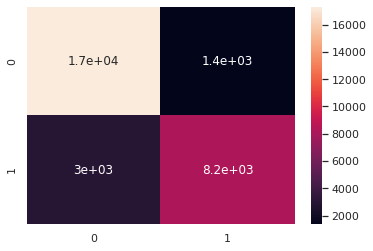

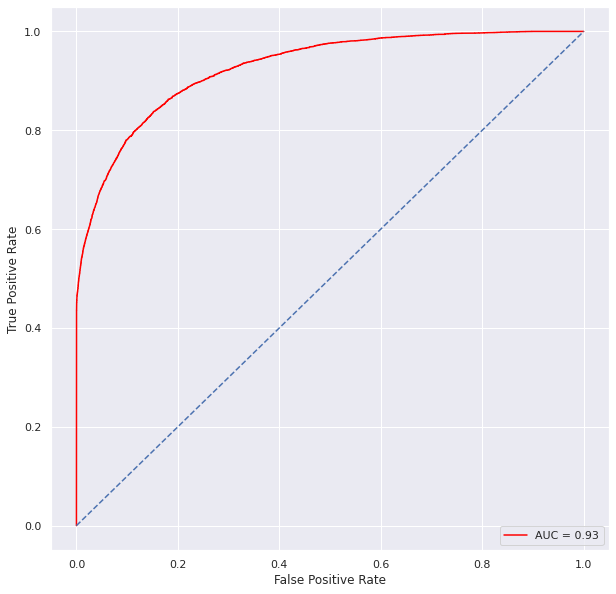

In [ ]:
params = { 
    'n_estimators': [200, 500, 1000]
}

ada_best_params, ada_learned_model, ada_model_metrics = learn_and_test_model(AdaBoostClassifier, params, x_train, y_train, x_test, y_test)

### 4.6. Logistic Regression

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 12.4min finished



Best CV error	0.16564664739578816


Best parameters:

	 solver 	 liblinear
	 C 	 8.68511373751352

Train error:	0.16526691981237435
Test error:	0.16507521693972593

Metrics:

{'acc': 0.8349247830602741, 'recall': 0.6700339710352226, 'precision': 0.8584354598556866, 'auc': 0.8971269387322852, 'train_error': 0.16526691981237435, 'test_error': 0.16507521693972593}


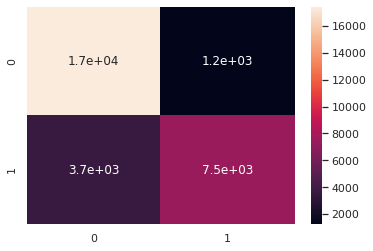

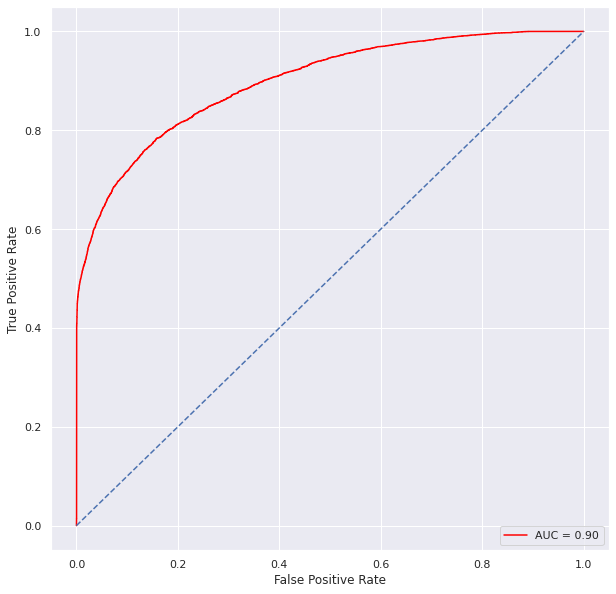

In [ ]:
params = { 
    'solver': ['liblinear'],
    'C': np.logspace(-2, 2, 50)
}

lr_best_params, lr_learned_model, lr_model_metrics = learn_and_test_model(LogisticRegression, params, x_train, y_train, x_test, y_test)

### 4.7. Naive Bayes

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished



Best CV error	0.24633686818521972


Best parameters:


Train error:	0.24861514406968951
Test error:	0.2533252923241867

Metrics:

{'acc': 0.7466747076758133, 'recall': 0.34087251922045414, 'precision': 0.9530117470632342, 'auc': 0.782379378603666, 'train_error': 0.24861514406968951, 'test_error': 0.2533252923241867}


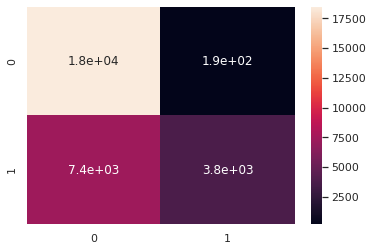

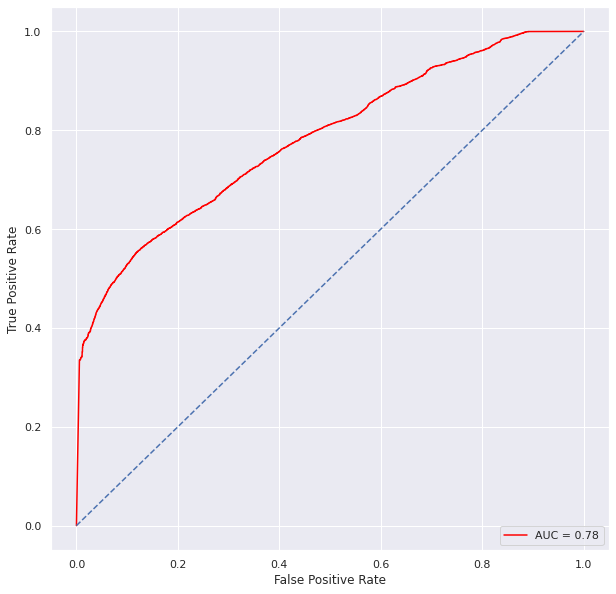

In [ ]:
params = {}

nb_best_params, nb_learned_model, nb_model_metrics = learn_and_test_model(GaussianNB, params, x_train, y_train, x_test, y_test)

### 5. Выводы

Text(0.5, 0, 'Feature Importances (%)')

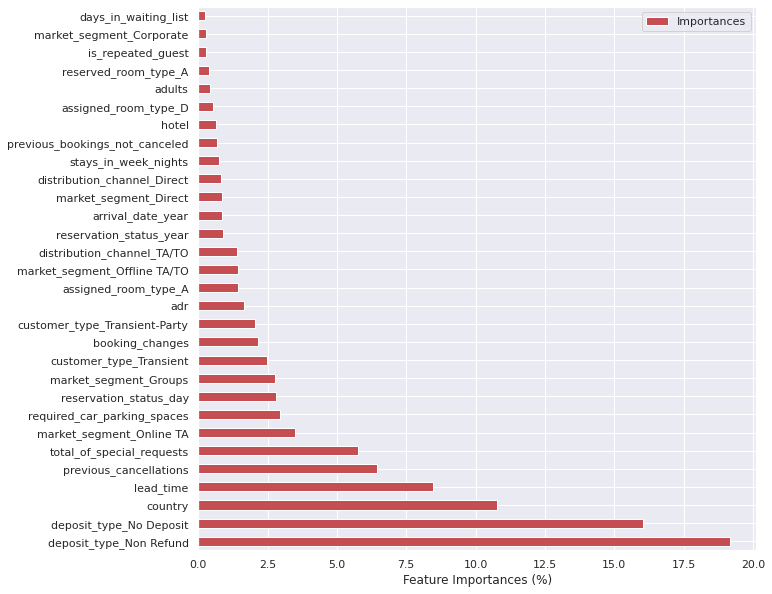

In [ ]:
importances = pd.DataFrame(data = forest_learned_model.feature_importances_*100,
                   columns = ["Importances"],
                   index = x_train.columns).sort_values("Importances", ascending = False)

importances[:30].plot(kind = "barh", color = "r", figsize=(10,10))
plt.xlabel("Feature Importances (%)")

In [ ]:
all_model_metric = [knn_model_metrics, tree_model_metrics, forest_model_metrics, ada_model_metrics, lr_model_metrics, nb_model_metrics]
acc= list(map(lambda x: x['acc'], all_model_metric))
recall= list(map(lambda x: x['recall'], all_model_metric))
precision = list(map(lambda x: x['precision'], all_model_metric))
roc_auc = list(map(lambda x: x['auc'], all_model_metric))
train_error = list(map(lambda x: x['train_error'], all_model_metric))
test_error = list(map(lambda x: x['test_error'], all_model_metric))

table = pd.DataFrame({"Model": [ "kNN", "Decision Tree", "Random Forest", "AdaBoost", "Logistic Regression",
                                "Naive Bayes"],
                     "Train Error": train_error,
                     "Test Error": test_error,
                     "Accuracy Scores": acc,
                     "Recall Scores": recall,
                     "Precision Scores": precision,
                     "ROC | Auc": roc_auc})


table["Model"] = table["Model"].astype("category")
table["Train Error"] = table["Train Error"].astype("float32")
table["Test Error"] = table["Test Error"].astype("float32")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")
table["Recall Scores"] = table["Accuracy Scores"].astype("float32")
table["Precision Scores"] = table["Accuracy Scores"].astype("float32")
table["ROC | Auc"] = table["ROC | Auc"].astype("float32")

pd.pivot_table(table, index = ["Model"]).sort_values(by = 'Test Error', ascending=True)

,Accuracy Scores,Precision Scores,ROC | Auc,Recall Scores,Test Error,Train Error
Model,,,,,,
Decision Tree,0.871813,0.871813,0.934296,0.871813,0.128187,0.104657
kNN,0.868865,0.868865,0.912523,0.868865,0.131135,0.068327
AdaBoost,0.854022,0.854022,0.926932,0.854022,0.145978,0.142774
Logistic Regression,0.834925,0.834925,0.897127,0.834925,0.165075,0.165267
Random Forest,0.802526,0.802526,0.921461,0.802526,0.197474,0.192875
Naive Bayes,0.746675,0.746675,0.782379,0.746675,0.253325,0.248615


Итак, сделаем выводы по результатом обучения моделей:


*   Модели для бинарной классификации лучше выбирать по ошибке на тестовой выборке и самые лучшие показатели имеет дерево решений. У этой модели также самые высокие оценки по остальным метрикам.
*   Как следует из графика важности признаков, для предсказания отмены важно наличие депозита, страна (было замечено на этапе визуализации), а также время до заселения, за которое делается бронирование
*   Точность моделей довольно низкая - у дерева решений ошибка 12%. Поэтому имеет смысл дополнительно порабоать данные(например над шумом) или же посмотреть в сторону нелинейных моделей для классификации, то есть нейронных сетей. 

# Часть №2: Principal Component Analysis

## 1. Визуализация PCA и выбор эффективной размерности

Для получения векторов главных компонент воспользуемся `sklearn`. Реализация PCA основана на сингулярном разложении.

In [ ]:
from sklearn.decomposition import PCA

Для визуализации точек задаем количество компонент 

In [ ]:
pca = PCA(n_components=2)

Используем уже стандартизированные данные, так как для выбора количества компонент желательно, чтобы данные были центрированны и нормированны - в таком случае доли объясненной дисперсии более-менее выровненные, то есть каждый компонент имеет значение. 

In [ ]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
Z = pca.transform(X)

Проверим, что количество признаков действитльно изменилось:

In [ ]:
print("{}\t->\t{}".format(X.shape, Z.shape))

(119387, 61)	->	(119387, 2)


In [ ]:
pca.components_

array([[-1.17974927e-01, -1.77168424e-01,  1.42662542e-01,
         7.27702421e-02,  1.04545065e-01,  3.45212432e-02,
        -1.49206562e-01, -2.51456427e-04, -7.79526895e-02,
        -2.97844505e-03,  4.71085906e-02, -9.25158932e-02,
         2.06936629e-01,  9.63940764e-02,  1.82278041e-01,
         1.85344564e-01, -5.31657083e-02,  1.29218262e-02,
        -2.89789541e-02, -1.85090486e-02,  1.07839904e-02,
         5.80307261e-03,  1.16902302e-02, -3.75601540e-02,
         1.31591835e-01, -2.53730439e-01, -1.34087605e-01,
         2.29197353e-01, -4.86263688e-02,  1.14508609e-01,
         4.83928905e-03, -6.91661340e-02, -3.30638326e-01,
         2.07011607e-02,  5.11256310e-02,  2.21350219e-01,
         1.28085275e-01,  1.01829242e-01,  9.20979187e-02,
         5.19817707e-02,  2.90855430e-03,  9.08333381e-04,
        -3.14830682e-01,  8.92823838e-03,  3.59946539e-02,
         1.96212386e-01,  1.21573744e-01,  1.02926554e-01,
         9.49390817e-02,  5.05679909e-02,  9.07149832e-0

In [ ]:
pca.explained_variance_

array([4.93340353, 3.62776459])

In [ ]:
pca.explained_variance_ratio_

array([0.08087547, 0.05947155])

### 1.1. Визуализациия точек для `n_components=2`

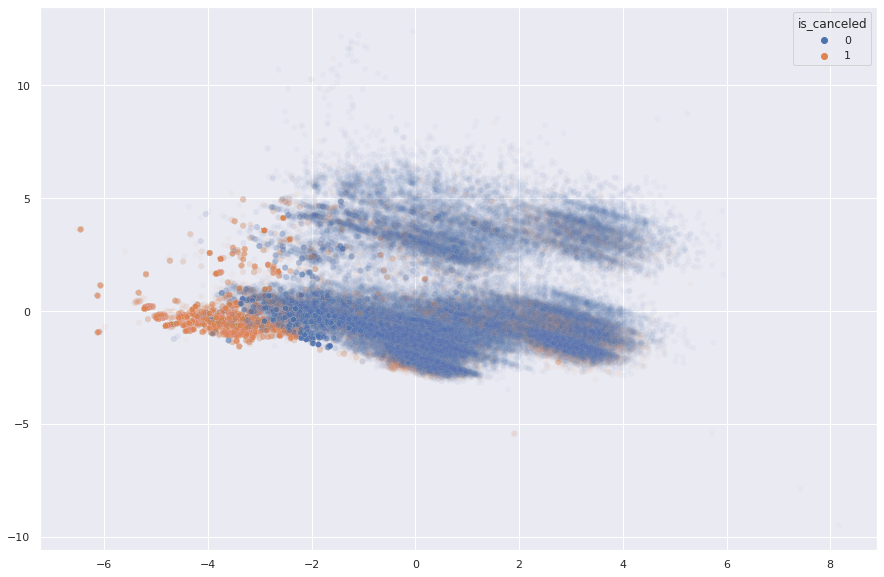

In [ ]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=Y, alpha=0.04)

pass

По результатам визуализации какого то четкого разделения между классами не наблюдается. 

### 1.2. Эффективная размерность выборки 

In [ ]:
pca = PCA()
pca.fit(X)
Z = pca.transform(X)

In [ ]:
em = []
down = pow(pca.singular_values_, 2).sum()

for m in range (1, Z.shape[1]):
  up = 0
  for i in range (m, Z.shape[1]):
    up+=pow(pca.singular_values_, 2)[i]
  em.append(up/down)

In [ ]:
em

[0.9191245318017074,
 0.8596528396521561,
 0.8130394816240324,
 0.7714729645085402,
 0.732488468308175,
 0.6990687898653958,
 0.6660098911700777,
 0.6332543988484821,
 0.6016038828841347,
 0.5702581851012951,
 0.5402548689189381,
 0.511357885918629,
 0.48439757267078193,
 0.45859468628962274,
 0.43552006882989586,
 0.41287107670002715,
 0.3918372986921751,
 0.37225430562227607,
 0.3534138823592595,
 0.3349394174904057,
 0.31751471494471345,
 0.300130649542063,
 0.2832110492116431,
 0.26665642864071776,
 0.2501776471946134,
 0.2337635553149267,
 0.21747778760293737,
 0.20174076354270612,
 0.1861837611561355,
 0.1712000428654109,
 0.1572136525336944,
 0.14351671134705854,
 0.1300598998276819,
 0.11717884770198084,
 0.10501785516463508,
 0.09343803823184042,
 0.08265992079879456,
 0.07295451541104225,
 0.06330903211646527,
 0.05422651583727332,
 0.04573026703151102,
 0.038618619358746845,
 0.03219793876491039,
 0.026010120472935695,
 0.02081598528520695,
 0.015743358011360575,
 0.01198149

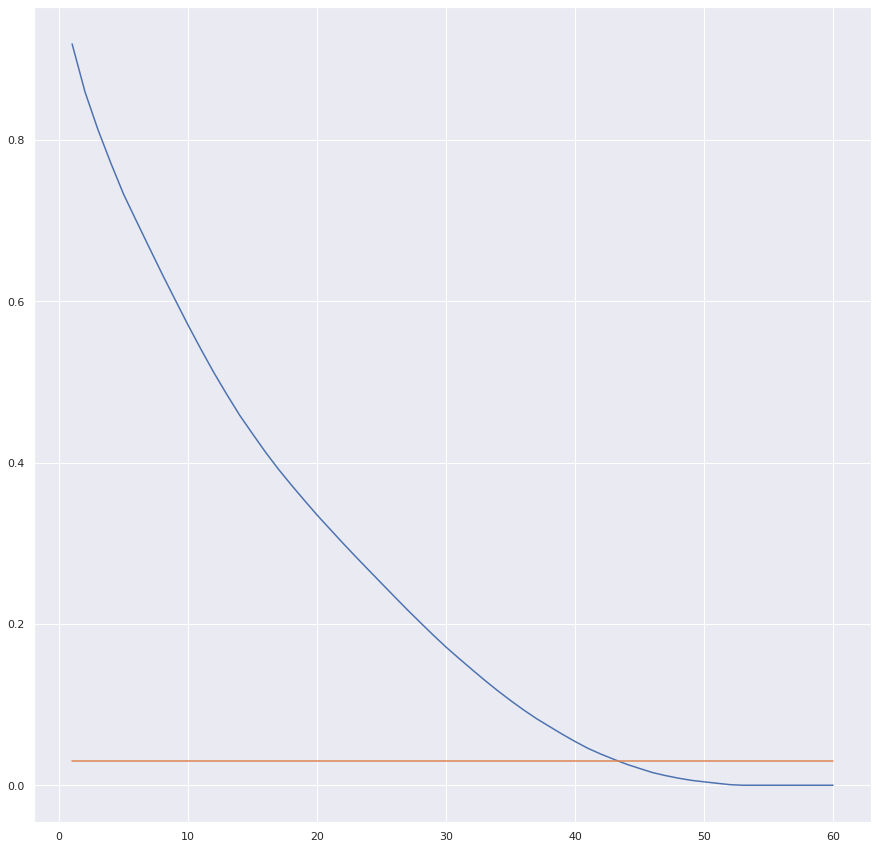

In [ ]:
plt.figure(figsize = (15, 15))

sns.lineplot(x=range(1, Z.shape[1]), y=em)
sns.lineplot(x=range(1, Z.shape[1]), y=[0.03]*(Z.shape[1]-1))
pass

Судя по графику, критерием "крутого" склона воспользоваться нельзя, так как этого самого склона не наблюдается, однака если посмотреть на значения напрямую, видно, что условие "крутого" склона выполняется для элемента с индексом `54`. 

В таком случае для определения эффективного количества главных компонент, произведем для каждого классификатора перебор значений от `45` до `55` и сравним ошибки на тестовой и тренировочной выборках.

## 2. Классификация на новых данных

Чтобы не перезапускать вычисления, вручную сохраним оптимальные значения гиперпараметров для рассмотренных ранее классификаторов:

In [ ]:
knn_best_params = {"n_neighbors": 3}
dt_best_params = {"max_depth": 14, "min_samples_split": 4}
rf_best_params = {"n_estimators": 1000, "max_depth": 8, "min_samples_split": 4}
ab_best_params = {"n_estimators": 1000}
lr_best_params = {"C": 10.481131341546853, "solver": "liblinear"}
nb_best_params = {}

Графики зависимости ошибки от количества компонент будут построены в отдельности для каждого классификатора. Напишем соответствующие функции:

In [ ]:
def plot_pca_n_component_error(n_comp_range, train_error, test_error):
  plt.figure(figsize = (10, 10))
  sns.lineplot(x=n_comp_range, y=train_error)
  sns.lineplot(x=n_comp_range, y=test_error)

In [ ]:
def learn_and_test_rca(model, params, X, Y, n_comp_range, probability=True):
  models = []

  metrics_pca = {
        'n_components': [],
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': [],
        'train_error': [],
        'test_error': []
    }

  for i in n_comp_range:
    pca = PCA(n_components=i)
    pca.fit(X)
    Z = pca.transform(X)
    x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size = 0.25, random_state = 42)

    _, knn_model, metrics = learn_and_test_model(model, params, x_train, y_train, x_test, y_test, grid_search=False, verbose=False, probability=probability)
    models.append(knn_model)
    metrics_pca['acc'].append(metrics['acc'])
    metrics_pca['recall'].append(metrics['recall'])
    metrics_pca['precision'].append(metrics['precision'])
    metrics_pca['auc'].append(metrics['auc'])
    metrics_pca['train_error'].append(metrics['train_error'])
    metrics_pca['test_error'].append(metrics['test_error'])
    metrics_pca['n_components'].append(i)

    print("Learned model with {} components: {}".format(i, metrics))

  plot_pca_n_component_error(metrics_pca['n_components'], metrics_pca['train_error'], metrics_pca['test_error'])
  
  best_n_comp =  min((val, idx) for (idx, val) in enumerate(metrics_pca['test_error']))
  return best_n_comp[1], models[best_n_comp[1]], metrics_pca

### 2.1. Рассмотренные ранее классификаторы

#### 2.1.1. Метод ближайшего соседа

Learned model with 45 components: {'acc': 0.8670888196468657, 'recall': 0.7956374038977293, 'precision': 0.8411303279463189, 'auc': 0.9113286770834264, 'train_error': 0.06896359169086441, 'test_error': 0.13291118035313432}
Learned model with 46 components: {'acc': 0.8674908701041981, 'recall': 0.7959949937421777, 'precision': 0.8418266048974189, 'auc': 0.9114484397879477, 'train_error': 0.06899709626982355, 'test_error': 0.13250912989580194}
Learned model with 47 components: {'acc': 0.8675913827185312, 'recall': 0.7960843912032898, 'precision': 0.842000756429652, 'auc': 0.9114697076743741, 'train_error': 0.06898592807683716, 'test_error': 0.13240861728146883}
Learned model with 48 components: {'acc': 0.8673903574898649, 'recall': 0.7956374038977293, 'precision': 0.841846386681801, 'auc': 0.911208147882266, 'train_error': 0.06893008711190529, 'test_error': 0.13260964251013502}
Learned model with 49 components: {'acc': 0.8673568532850873, 'recall': 0.7955480064366172, 'precision': 0.8418

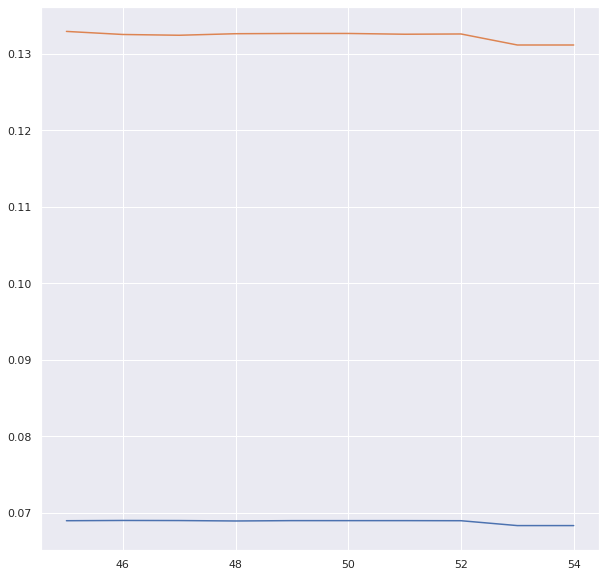

In [ ]:
knn_best_n_comp, knn_best_model_pca, knn_metrics_pca = learn_and_test_rca(KNeighborsClassifier, knn_best_params, X, Y, range(45, 55))

In [ ]:
knn_metrics_pca_best = {}
for key in knn_metrics_pca:
  knn_metrics_pca_best[key] = knn_metrics_pca[key][knn_best_n_comp]

In [ ]:
print("Knn classifier is the best with {} components: {}".format(knn_metrics_pca_best['n_components'], knn_metrics_pca_best))

Knn classifier is the best with 53 components: {'n_components': 53, 'acc': 0.8688645425000837, 'recall': 0.7975147505810835, 'precision': 0.84399243140965, 'auc': 0.9125226824320206, 'train_error': 0.06832700469064105, 'test_error': 0.13113545749991623}


#### 2.1.2. Дерево решений

Деревья учатся быстро, поэтому можем взять более широкий диапазон количества главных компонент.

Learned model with 10 components: {'acc': 0.8436358763024759, 'recall': 0.7121401752190237, 'precision': 0.8462764262190587, 'auc': 0.8859108365311494, 'train_error': 0.11406075496984588, 'test_error': 0.15636412369752403}
Learned model with 11 components: {'acc': 0.8451770697222502, 'recall': 0.701233684963347, 'precision': 0.8598048887427381, 'auc': 0.8897587454703523, 'train_error': 0.11713200804109895, 'test_error': 0.15482293027774985}
Learned model with 12 components: {'acc': 0.8424632291352565, 'recall': 0.7237618451635973, 'precision': 0.8339513803049031, 'auc': 0.8863412100220623, 'train_error': 0.11906410542774179, 'test_error': 0.15753677086474352}
Learned model with 13 components: {'acc': 0.8414245987871478, 'recall': 0.7062399427856249, 'precision': 0.8451909703648229, 'auc': 0.8884659650533295, 'train_error': 0.11726602635693545, 'test_error': 0.1585754012128522}
Learned model with 14 components: {'acc': 0.842630750159145, 'recall': 0.7189343822635437, 'precision': 0.8381

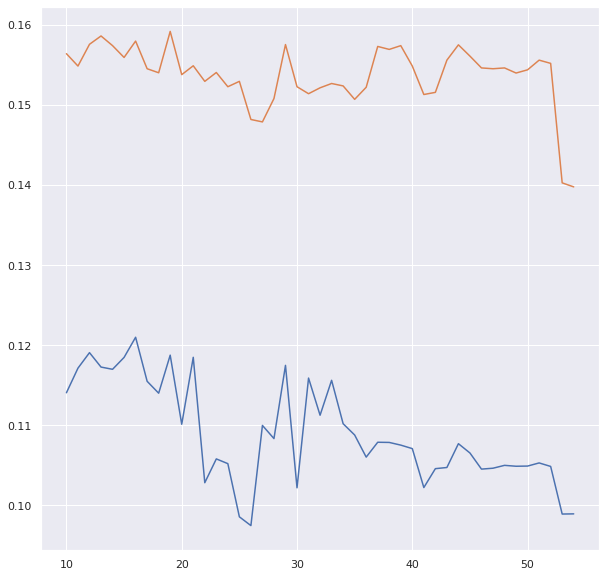

In [ ]:
tree_best_n_comp, tree_best_model_pca, tree_model_metrics_pca = learn_and_test_rca(DecisionTreeClassifier, dt_best_params, X, Y, range(10, 55))

In [ ]:
tree_metrics_pca_best = {}
for key in tree_model_metrics_pca:
  tree_metrics_pca_best[key] = tree_model_metrics_pca[key][tree_best_n_comp]

In [ ]:
print("Decision Tree classifier is the best with {} components: {}".format(tree_metrics_pca_best['n_components'], tree_metrics_pca_best))

Decision Tree classifier is the best with 54 components: {'n_components': 54, 'acc': 0.8602539618722149, 'recall': 0.7432504916860361, 'precision': 0.8648704878809945, 'auc': 0.9047153464785654, 'train_error': 0.09895018985928077, 'test_error': 0.13974603812778505}


#### 2.1.3. Random Forest

Learned model with 45 components: {'acc': 0.8174690923710926, 'recall': 0.5434471661004827, 'precision': 0.9468847352024922, 'auc': 0.9104554769265205, 'train_error': 0.17480455662273844, 'test_error': 0.18253090762890742}
Learned model with 46 components: {'acc': 0.8179716554427581, 'recall': 0.545413910244949, 'precision': 0.9460381454489069, 'auc': 0.9108025657670163, 'train_error': 0.17472637927183382, 'test_error': 0.18202834455724193}
Learned model with 47 components: {'acc': 0.8170670419137602, 'recall': 0.5444305381727159, 'precision': 0.9436008676789588, 'auc': 0.9106918117933038, 'train_error': 0.1753964708510163, 'test_error': 0.18293295808623983}
Learned model with 48 components: {'acc': 0.8168995208898717, 'recall': 0.5409440371893438, 'precision': 0.9482839680300893, 'auc': 0.9112538789879825, 'train_error': 0.1757091802546348, 'test_error': 0.18310047911012833}
Learned model with 49 components: {'acc': 0.8181391764666466, 'recall': 0.5475594493116396, 'precision': 0.9434

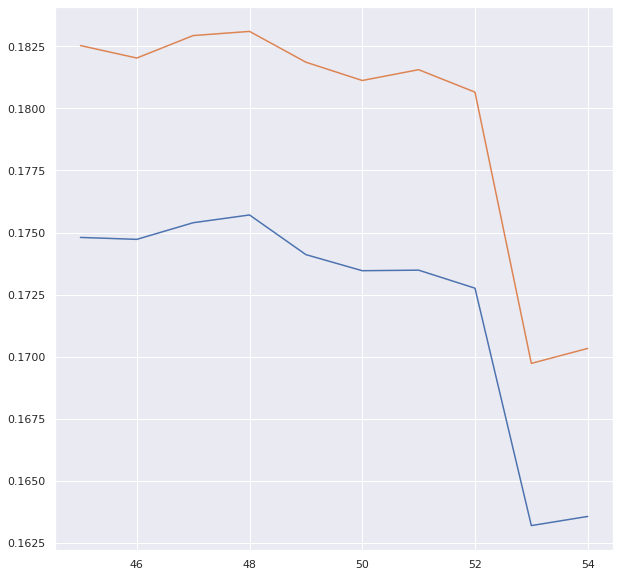

In [ ]:
forest_best_n_comp, forest_best_model_pca, forest_model_metrics_pca = learn_and_test_rca(RandomForestClassifier, rf_best_params, X, Y, range(45, 55))

In [ ]:
forest_metrics_pca_best = {}
for key in forest_model_metrics_pca:
  forest_metrics_pca_best[key] = forest_model_metrics_pca[key][forest_best_n_comp]

In [ ]:
print("Random Forest classifier is the best with {} components: {}".format(forest_metrics_pca_best['n_components'], forest_metrics_pca_best))

Random Forest classifier is the best with 53 components: {'n_components': 53, 'acc': 0.8302676985961738, 'recall': 0.5649025567673878, 'precision': 0.96946916231973, 'auc': 0.9176333921884584, 'train_error': 0.16320080410989501, 'test_error': 0.16973230140382617}


#### 2.1.4. AdaBoost 

Learned model with 45 components: {'acc': 0.839615371729152, 'recall': 0.7175934203468621, 'precision': 0.8313827032625583, 'auc': 0.9099179352289836, 'train_error': 0.15131784677239224, 'test_error': 0.16038462827084798}
Learned model with 46 components: {'acc': 0.839849901162596, 'recall': 0.7190237797246558, 'precision': 0.8308884297520661, 'auc': 0.9101680478728507, 'train_error': 0.15161938798302435, 'test_error': 0.16015009883740408}
Learned model with 47 components: {'acc': 0.8418266492444801, 'recall': 0.720007151796889, 'precision': 0.8352172560406512, 'auc': 0.9117723708487416, 'train_error': 0.15021219566674113, 'test_error': 0.15817335075551983}
Learned model with 48 components: {'acc': 0.8441049351693638, 'recall': 0.7242982299302699, 'precision': 0.8377623823803123, 'auc': 0.9119905924418278, 'train_error': 0.14963144963144964, 'test_error': 0.15589506483063625}
Learned model with 49 components: {'acc': 0.8420946828827017, 'recall': 0.7225102807080279, 'precision': 0.8339

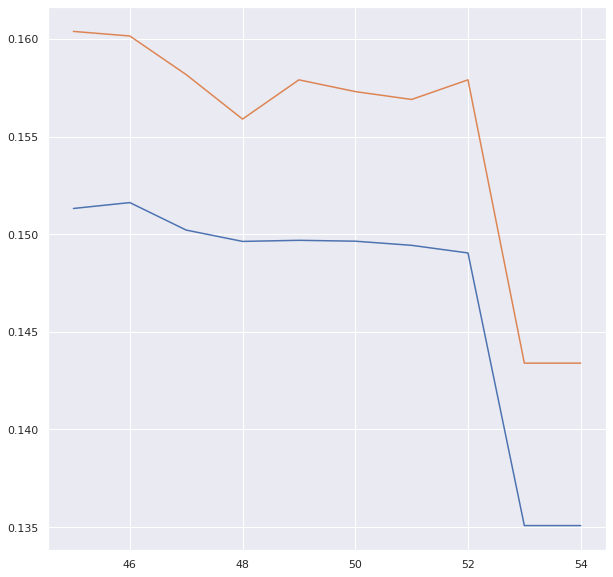

In [ ]:
ada_best_n_comp, ada_best_model_pca, ada_model_metrics_pca = learn_and_test_rca(AdaBoostClassifier, ab_best_params, X, Y, range(45, 55))

In [ ]:
ada_metrics_pca_best = {}
for key in ada_model_metrics_pca:
  ada_metrics_pca_best[key] = ada_model_metrics_pca[key][ada_best_n_comp]

In [ ]:
print("AdaBoost classifier is the best with {} components: {}".format(ada_metrics_pca_best['n_components'],ada_metrics_pca_best))

AdaBoost classifier is the best with 53 components: {'n_components': 53, 'acc': 0.8566020035514457, 'recall': 0.743161094224924, 'precision': 0.855246913580247, 'auc': 0.923184789606206, 'train_error': 0.13507929417020326, 'test_error': 0.1433979964485543}


#### 2.1.5. Logistic Regression 

Learned model with 10 components: {'acc': 0.7617180956210005, 'recall': 0.4413552655104595, 'precision': 0.8512068965517241, 'auc': 0.7973366694588543, 'train_error': 0.2346660710297074, 'test_error': 0.23828190437899957}
Learned model with 11 components: {'acc': 0.7617515998257781, 'recall': 0.43849454675487215, 'precision': 0.8552746294681779, 'auc': 0.8014696528698645, 'train_error': 0.2337726155907974, 'test_error': 0.23824840017422186}
Learned model with 12 components: {'acc': 0.7619191208496666, 'recall': 0.43760057214375114, 'precision': 0.8572679509632224, 'auc': 0.8016679790845679, 'train_error': 0.2339178020996203, 'test_error': 0.23808087915033338}
Learned model with 13 components: {'acc': 0.7642644151841056, 'recall': 0.44367959949937424, 'precision': 0.8592451523545707, 'auc': 0.8037212606995625, 'train_error': 0.23300201027473755, 'test_error': 0.2357355848158944}
Learned model with 14 components: {'acc': 0.7694240627198713, 'recall': 0.46880028607187557, 'precision': 0.8

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Learned model with 49 components: {'acc': 0.8120749154018829, 'recall': 0.632755229751475, 'precision': 0.8250378832031705, 'auc': 0.8810958531544972, 'train_error': 0.18864194773285684, 'test_error': 0.18792508459811708}
Learned model with 50 components: {'acc': 0.811840385968439, 'recall': 0.6333810119792598, 'precision': 0.8238372093023256, 'auc': 0.881584700757748, 'train_error': 0.18827339736430646, 'test_error': 0.18815961403156095}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Learned model with 51 components: {'acc': 0.8139176466646564, 'recall': 0.6353477561237261, 'precision': 0.8281286413423444, 'auc': 0.8822303256672714, 'train_error': 0.18686620504802323, 'test_error': 0.1860823533353436}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Learned model with 52 components: {'acc': 0.8130130331356585, 'recall': 0.6346325764348293, 'precision': 0.8261375538228791, 'auc': 0.8817600177014735, 'train_error': 0.18748045566227384, 'test_error': 0.18698696686434146}
Learned model with 53 components: {'acc': 0.8349247830602741, 'recall': 0.6700339710352226, 'precision': 0.8584354598556866, 'auc': 0.8971298945349488, 'train_error': 0.165255751619388, 'test_error': 0.16507521693972593}
Learned model with 54 components: {'acc': 0.8349247830602741, 'recall': 0.6700339710352226, 'precision': 0.8584354598556866, 'auc': 0.8971298945349488, 'train_error': 0.165255751619388, 'test_error': 0.16507521693972593}


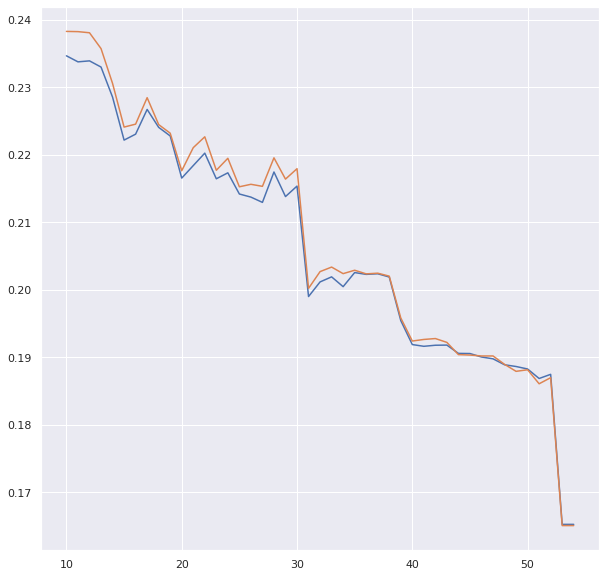

In [ ]:
lr_best_n_comp, lr_best_model_pca, lr_model_metrics_pca = learn_and_test_rca(LogisticRegression, lr_best_params, X, Y, range(10, 55))

In [ ]:
lr_metrics_pca_best = {}
for key in lr_model_metrics_pca:
  lr_metrics_pca_best[key] = lr_model_metrics_pca[key][lr_best_n_comp]

In [ ]:
print("Logistic Regression classifier is the best with {} components: {}".format(lr_metrics_pca_best['n_components'],lr_metrics_pca_best))

Logistic Regression classifier is the best with 53 components: {'n_components': 53, 'acc': 0.8349247830602741, 'recall': 0.6700339710352226, 'precision': 0.8584354598556866, 'auc': 0.8971298945349488, 'train_error': 0.165255751619388, 'test_error': 0.16507521693972593}


#### 2.1.6. Naive Bayes 

Learned model with 10 components: {'acc': 0.7397058330820518, 'recall': 0.33282674772036475, 'precision': 0.9240506329113924, 'auc': 0.7288762412898078, 'train_error': 0.25702479338842976, 'test_error': 0.2602941669179482}
Learned model with 11 components: {'acc': 0.7397058330820518, 'recall': 0.32263543715358484, 'precision': 0.9494869771112865, 'auc': 0.7375404797653846, 'train_error': 0.25622068349341076, 'test_error': 0.2602941669179482}
Learned model with 12 components: {'acc': 0.7400408751298287, 'recall': 0.3200429107813338, 'precision': 0.9590141976962229, 'auc': 0.7347691896098352, 'train_error': 0.25613133794951976, 'test_error': 0.2599591248701712}
Learned model with 13 components: {'acc': 0.7405099339967166, 'recall': 0.3200429107813338, 'precision': 0.9626243613874698, 'auc': 0.7277116550403337, 'train_error': 0.25610900156354705, 'test_error': 0.2594900660032834}
Learned model with 14 components: {'acc': 0.7406439508158273, 'recall': 0.3249597711424996, 'precision': 0.950

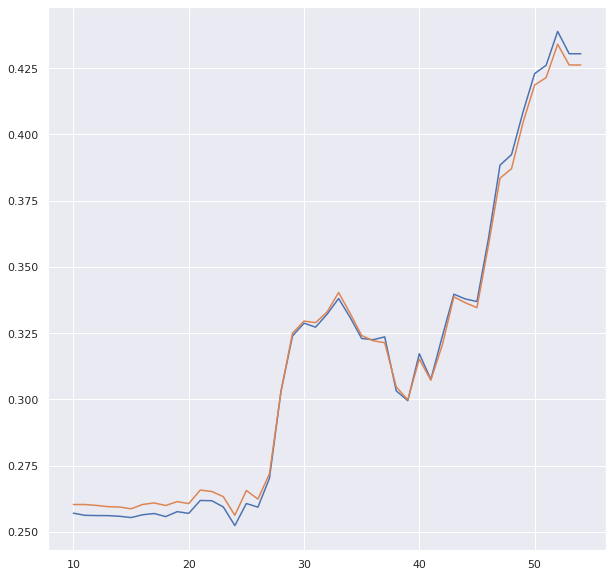

In [ ]:
nb_best_n_comp, nb_best_model_pca, nb_model_metrics_pca = learn_and_test_rca(GaussianNB, nb_best_params, X, Y, range(10, 55))

In [ ]:
nb_metrics_pca_best = {}
for key in nb_model_metrics_pca:
  nb_metrics_pca_best[key] = nb_model_metrics_pca[key][nb_best_n_comp]

In [ ]:
print("Naive Bayes  classifier is the best with {} components: {}".format(nb_metrics_pca_best['n_components'],nb_metrics_pca_best))

Naive Bayes  classifier is the best with 24 components: {'n_components': 24, 'acc': 0.7437598418601534, 'recall': 0.32951904165921686, 'precision': 0.9613980177360459, 'auc': 0.7483302253970555, 'train_error': 0.2523453205271387, 'test_error': 0.2562401581398466}


### 2.2. SVM классификатор

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kernel=linear ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... kernel=linear, score=0.839, total=10.5min
[CV] kernel=linear ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.5min remaining:    0.0s


[CV] ....................... kernel=linear, score=0.840, total=10.5min
[CV] kernel=linear ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.0min remaining:    0.0s


[CV] ....................... kernel=linear, score=0.838, total=10.7min
[CV] kernel=poly .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 31.6min remaining:    0.0s


[CV] ......................... kernel=poly, score=0.843, total= 6.5min
[CV] kernel=poly .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 38.1min remaining:    0.0s


[CV] ......................... kernel=poly, score=0.850, total= 5.8min
[CV] kernel=poly .....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 43.9min remaining:    0.0s


[CV] ......................... kernel=poly, score=0.846, total= 5.8min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 49.7min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.869, total= 5.4min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 55.0min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.868, total= 5.1min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 60.1min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.867, total= 5.1min
[CV] kernel=sigmoid ..................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 65.2min remaining:    0.0s


[CV] ...................... kernel=sigmoid, score=0.739, total= 6.2min
[CV] kernel=sigmoid ..................................................
[CV] ...................... kernel=sigmoid, score=0.736, total= 6.6min
[CV] kernel=sigmoid ..................................................
[CV] ...................... kernel=sigmoid, score=0.732, total= 6.0min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 83.9min finished



Best CV error	0.13226492316619376


Best parameters:

	 kernel 	 rbf

Train error:	0.12547464820192092
Test error:	0.13123597011424934

Metrics:

{'acc': 0.8687640298857506, 'recall': 0.7163418558912927, 'precision': 0.9150393970537856, 'auc': -1, 'train_error': 0.12547464820192092, 'test_error': 0.13123597011424934}


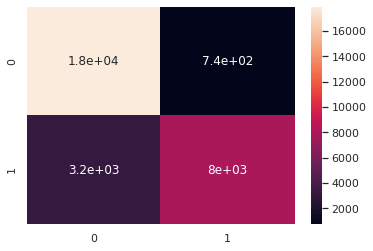

In [ ]:
params = { 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    # 'C': np.logspace(-2, 2, 3)
}

svm_best_params, svm_learned_model, svm_model_metrics = learn_and_test_model(SVC, params, x_train, y_train, x_test, y_test, probability=False)

In [ ]:
svm_best_params = { 'kernel': 'rbf'}

Learned model with 45 components: {'acc': 0.8566355077562234, 'recall': 0.7118719828356874, 'precision': 0.882913848541967, 'auc': -1, 'train_error': 0.1375474648201921, 'test_error': 0.1433644922437766}
Learned model with 46 components: {'acc': 0.8565014909371126, 'recall': 0.7120507777579117, 'precision': 0.8823529411764706, 'auc': -1, 'train_error': 0.13743578289032835, 'test_error': 0.14349850906288739}
Learned model with 47 components: {'acc': 0.8566355077562234, 'recall': 0.7121401752190237, 'precision': 0.8826592797783933, 'auc': -1, 'train_error': 0.13734643734643734, 'test_error': 0.1433644922437766}
Learned model with 48 components: {'acc': 0.8571045666231112, 'recall': 0.71240836760236, 'precision': 0.8837750914938449, 'auc': -1, 'train_error': 0.13716774625865535, 'test_error': 0.1428954333768888}
Learned model with 49 components: {'acc': 0.8571715750326666, 'recall': 0.7128553549079206, 'precision': 0.8835457063711911, 'auc': -1, 'train_error': 0.13725709180254636, 'test_e

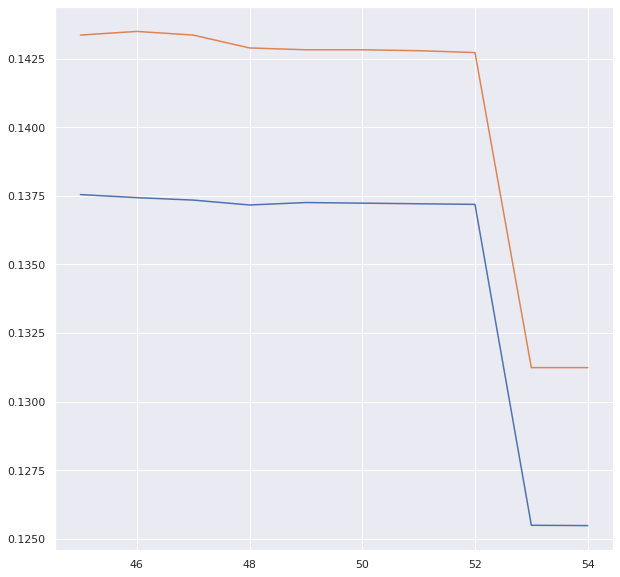

In [ ]:
svm_best_n_comp, svm_best_model_pca, svm_model_metrics_pca = learn_and_test_rca(SVC, svm_best_params, X, Y, range(45, 55), probability=False)

In [ ]:
svm_metrics_pca_best = {}
for key in svm_model_metrics_pca:
  svm_metrics_pca_best[key] = svm_model_metrics_pca[key][svm_best_n_comp]

In [ ]:
print("SVC classifier is the best with {} components: {}".format(svm_metrics_pca_best['n_components'],svm_metrics_pca_best))

SVC classifier is the best with 53 components: {'n_components': 53, 'acc': 0.8687640298857506, 'recall': 0.7163418558912927, 'precision': 0.9150393970537856, 'auc': -1, 'train_error': 0.1254858163949073, 'test_error': 0.13123597011424934}


## 3. Выводы


*   Применение метода главных компонент только ухудшило ошибку на тестовой выборке. Еще на этапе визуализации было понятно, что метод главных компонент применять не стоит. Это означает, что в данных объективно отсутствуют причины, заставляющие эти данные находиться в пространстве существенно меньшей размерности.
*  SVM классификатор имеет не самое худшее качество классификации, однако он все равно хуже, чем  дерево решений. 



# Часть №3: Нейронные сети

In [ ]:
def plot_nn_alpha_error(alpha_range, train_error, test_error):
  plt.figure(figsize = (10, 10))
  sns.lineplot(x=alpha_range, y=train_error)
  sns.lineplot(x=alpha_range, y=test_error)

In [ ]:
def learn_and_test_nn(model, params, x_train, y_train, x_test, y_test, alpha_range):
  models = []
  general_metrics = []

  metrics_nn = {
        'alpha': [],
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': [],
        'train_error': [],
        'test_error': []
    }

  for alpha in alpha_range:
    params['alpha'] = alpha
    best_params, learned_model, metrics = learn_and_test_model(model, params, x_train, y_train, x_test, y_test, grid_search = False, verbose = False)
    print("Best params for {} is {}".format(alpha, best_params))
    
    models.append(learned_model)
    general_metrics.append(best_params)

    metrics_nn['acc'].append(metrics['acc'])
    metrics_nn['recall'].append(metrics['recall'])
    metrics_nn['precision'].append(metrics['precision'])
    metrics_nn['auc'].append(metrics['auc'])
    metrics_nn['train_error'].append(metrics['train_error'])
    metrics_nn['test_error'].append(metrics['test_error'])
    metrics_nn['alpha'].append(alpha)

    print("Learned model with alpha {}: {}".format(alpha, metrics))

  plot_nn_alpha_error(metrics_nn['alpha'], metrics_nn['train_error'], metrics_nn['test_error'])
  
  best_alpha =  min((val, idx) for (idx, val) in enumerate(metrics_nn['test_error']))
  return general_metrics[best_alpha[1]], models[best_alpha[1]], metrics_nn

In [ ]:
def learn_and_test_nn_by_layer(model, params, x_train, y_train, x_test, y_test, neuron_count_input,neuron_count_range):
  models = []
  general_metrics = []

  metrics_nn = {
        'alpha': [],
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': [],
        'train_error': [],
        'test_error': [],
        'neuron_count': []
    }

  for neuron_count in neuron_count_range:
    params['hidden_layer_sizes'] = (neuron_count_input, neuron_count, neuron_count, 2)
    best_params, learned_model, metrics = learn_and_test_model(model, params, x_train, y_train, x_test, y_test, grid_search = False, verbose = False)
    print("Best params for {} is {}".format(neuron_count, best_params))
    
    models.append(learned_model)
    general_metrics.append(best_params)

    metrics_nn['acc'].append(metrics['acc'])
    metrics_nn['recall'].append(metrics['recall'])
    metrics_nn['precision'].append(metrics['precision'])
    metrics_nn['auc'].append(metrics['auc'])
    metrics_nn['train_error'].append(metrics['train_error'])
    metrics_nn['test_error'].append(metrics['test_error'])
    metrics_nn['neuron_count'].append(neuron_count)

    print("Learned model with neuron_count {}: {}".format(neuron_count, metrics))

  plot_nn_alpha_error(metrics_nn['neuron_count'], metrics_nn['train_error'], metrics_nn['test_error'])
  
  best_neuron_count =  min((val, idx) for (idx, val) in enumerate(metrics_nn['test_error']))
  return general_metrics[best_alpha[1]], models[best_neuron_count[1]], metrics_nn

In [ ]:
from sklearn.neural_network import MLPClassifier

input = len(data_raw.columns) - 1
params = { 
    'activation': 'logistic',
    'max_iter': 700,
    'random_state': 42
}

neuron_count_range = [50, 100, 200, 300, 400]
mlp_best_params, mlp_learned_model, mlp_model_metrics = learn_and_test_nn_by_layer(MLPClassifier, params, x_train, y_train, x_test, y_test, input, neuron_count_range)

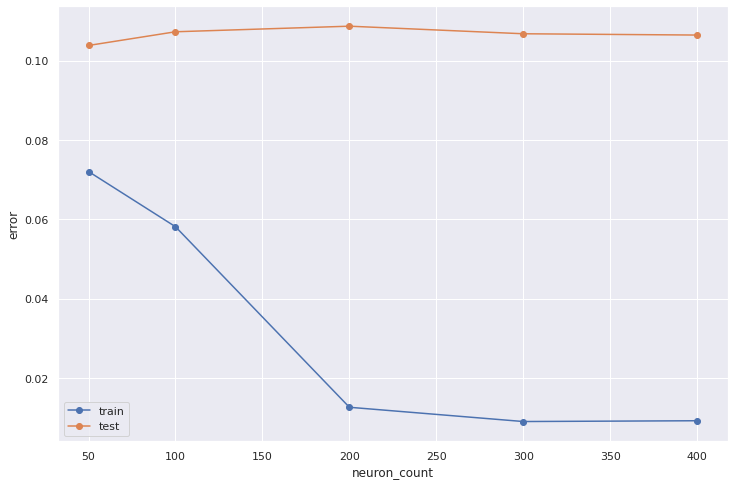

In [ ]:
train_err = mlp_model_metrics['train_error']
test_err = mlp_model_metrics['test_error']

plt.figure(figsize=(12,8))
plt.plot(neuron_count_range, train_err, '-o', label = 'train')
plt.plot(neuron_count_range, test_err, '-o', label = 'test')
plt.xlabel('neuron_count')
plt.ylabel('error')
plt.legend()
pass

In [ ]:
np.logspace(-5, 0, 10).tolist()

[1e-05,
 4.2986623470822724e-05,
 0.00018478497974222906,
 0.0007943282347242813,
 0.003414548873833601,
 0.01467799267622069,
 0.0630957344480193,
 0.27122725793320296,
 1.165914401179831,
 5.011872336272722]

Best params for 1e-05 is {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (61, 50, 50, 2), 'random_state': 42, 'alpha': 1e-05}
Learned model with alpha 1e-05: {'acc': 0.8939926960833584, 'recall': 0.8363132487037368, 'precision': 0.8752806886227545, 'auc': 0.9517253230934237, 'train_error': 0.06930980567344204, 'test_error': 0.10600730391664154}
Best params for 3.5938136638046256e-05 is {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (61, 50, 50, 2), 'random_state': 42, 'alpha': 3.5938136638046256e-05}
Learned model with alpha 3.5938136638046256e-05: {'acc': 0.8961034609843536, 'recall': 0.8144108707312713, 'precision': 0.8988653182042428, 'auc': 0.9531814990361354, 'train_error': 0.07076167076167077, 'test_error': 0.10389653901564647}
Best params for 0.0001291549665014884 is {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (61, 50, 50, 2), 'random_state': 42, 'alpha': 0.0001291549665014884}
Learned model with alpha 0.0001291549665014

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best params for 0.07742636826811278 is {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (61, 50, 50, 2), 'random_state': 42, 'alpha': 0.07742636826811278}
Learned model with alpha 0.07742636826811278: {'acc': 0.6252219653566523, 'recall': 0.0, 'precision': 0.0, 'auc': 0.8021924687815261, 'train_error': 0.3689635916908644, 'test_error': 0.37477803464334775}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best params for 0.2782559402207126 is {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (61, 50, 50, 2), 'random_state': 42, 'alpha': 0.2782559402207126}
Learned model with alpha 0.2782559402207126: {'acc': 0.6252219653566523, 'recall': 0.0, 'precision': 0.0, 'auc': 0.5693057805449413, 'train_error': 0.3689635916908644, 'test_error': 0.37477803464334775}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best params for 1.0 is {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (61, 50, 50, 2), 'random_state': 42, 'alpha': 1.0}
Learned model with alpha 1.0: {'acc': 0.6252219653566523, 'recall': 0.0, 'precision': 0.0, 'auc': 0.41014685184548394, 'train_error': 0.3689635916908644, 'test_error': 0.37477803464334775}


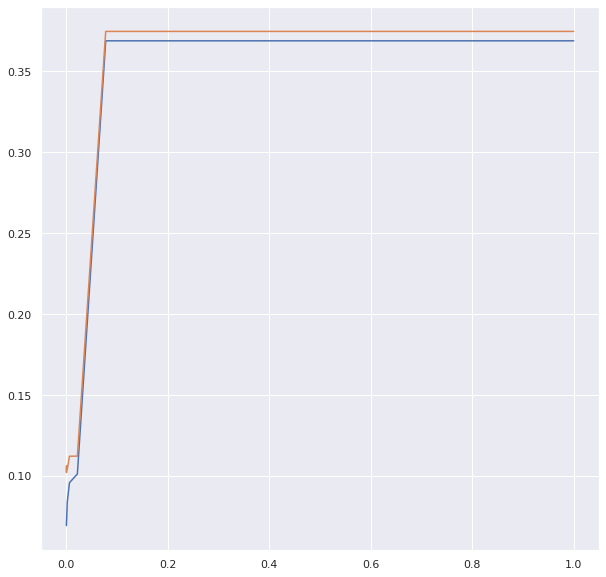

In [ ]:
params = { 
    'activation': 'logistic',
    'max_iter': 700,
    'hidden_layer_sizes': (input, 50, 50, 2),
    'random_state': 42
}

alpha_range = np.logspace(-5, 0, 10).tolist()

mlp_best_params, mlp_learned_model, mlp_model_metrics = learn_and_test_nn(MLPClassifier, params, x_train, y_train, x_test, y_test, alpha_range)

Metrics:
 {'alpha': [1e-05, 3.5938136638046256e-05, 0.0001291549665014884, 0.0004641588833612782, 0.0016681005372000592, 0.005994842503189409, 0.021544346900318846, 0.07742636826811278, 0.2782559402207126, 1.0], 'acc': [0.8939926960833584, 0.8961034609843536, 0.8979126880423494, 0.8938586792642477, 0.8960029483700205, 0.8878279224042618, 0.8877609139947064, 0.6252219653566523, 0.6252219653566523, 0.6252219653566523], 'recall': [0.8363132487037368, 0.8144108707312713, 0.8296978365814411, 0.804845342392276, 0.7991239048811014, 0.8317539781870195, 0.7854460933309494, 0.0, 0.0, 0.0], 'precision': [0.8752806886227545, 0.8988653182042428, 0.8904346157536218, 0.9013816579895875, 0.9125153123723969, 0.8638811513463324, 0.9024239934264585, 0.0, 0.0, 0.0], 'auc': [0.9517253230934237, 0.9531814990361354, 0.9547398968868481, 0.9531911329407651, 0.9561582749640554, 0.953566740246831, 0.9507565096667251, 0.8021924687815261, 0.5693057805449413, 0.41014685184548394], 'train_error': [0.0693098056734420

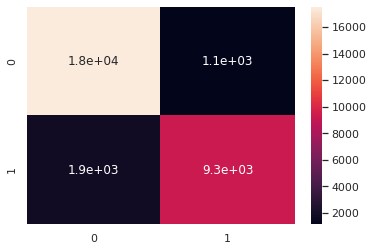

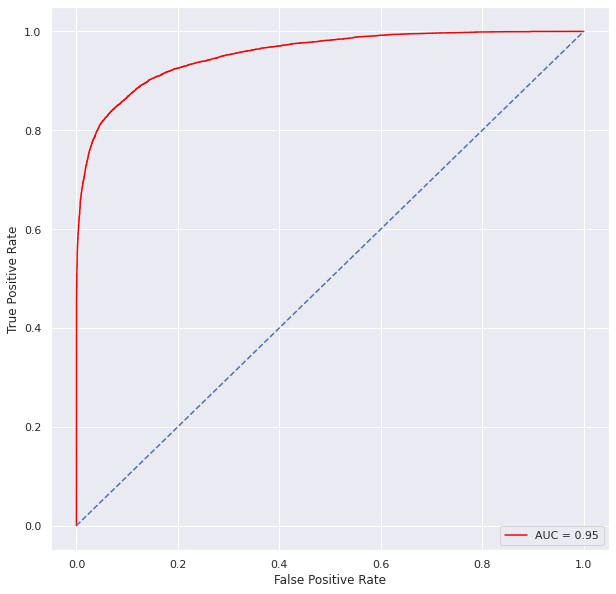

In [ ]:
y_test_predict = mlp_learned_model.predict(x_test)
y_prob = mlp_learned_model.predict_proba(x_test)[:,1]

print("Metrics:\n {}".format(mlp_model_metrics))
print(mlp_best_params)
CONFUSION(y_test, y_test_predict)
ROC(y_test, y_prob)

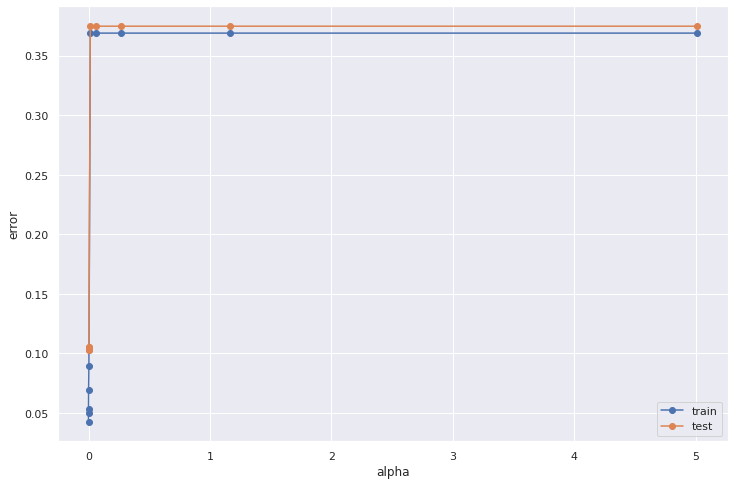

In [ ]:
train_err = mlp_model_metrics['train_error']
test_err = mlp_model_metrics['test_error']

plt.figure(figsize=(12,8))
plt.plot(alpha_range, train_err, '-o', label = 'train')
plt.plot(alpha_range, test_err, '-o', label = 'test')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

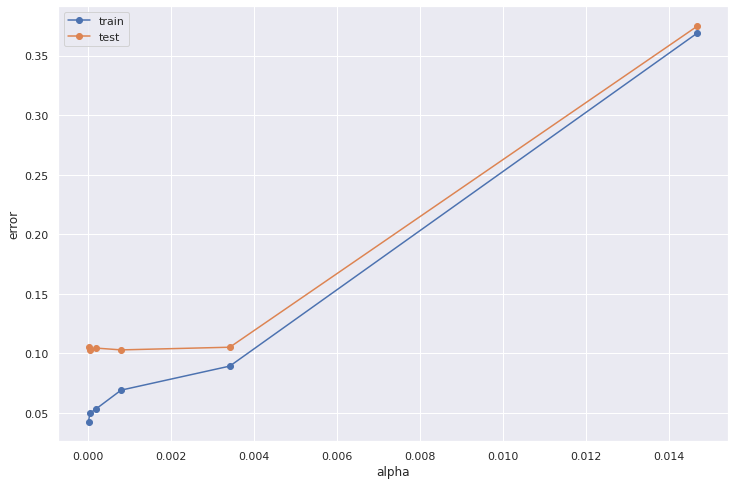

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(alpha_range[:6], train_err[:6], '-o', label = 'train')
plt.plot(alpha_range[:6], test_err[:6], '-o', label = 'test')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [ ]:
mlp_best_params = {'activation': 'logistic', 'max_iter': 700, 'hidden_layer_sizes': (input, 50, 50, 2), 'random_state': 42, 'alpha': 0.0001291549665014884}

Learned model with 45 components: {'acc': 0.8969745703085737, 'recall': 0.809047023064545, 'precision': 0.9059965962558815, 'auc': 0.9519674785440584, 'train_error': 0.06009604645968283, 'test_error': 0.10302542969142628}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 46 components: {'acc': 0.8946962843836902, 'recall': 0.8414983014482389, 'precision': 0.8729481591393861, 'auc': 0.9525572234533062, 'train_error': 0.053328121509939694, 'test_error': 0.10530371561630984}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 47 components: {'acc': 0.8928535531209166, 'recall': 0.8451635973538352, 'precision': 0.8657509157509158, 'auc': 0.9516990442352204, 'train_error': 0.05847665847665848, 'test_error': 0.10714644687908333}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 48 components: {'acc': 0.8927530405065836, 'recall': 0.8057393170033971, 'precision': 0.8976197589881486, 'auc': 0.9517572165395067, 'train_error': 0.05995085995085995, 'test_error': 0.10724695949341642}
Learned model with 49 components: {'acc': 0.8909773176533655, 'recall': 0.8360450563204005, 'precision': 0.8681767545488303, 'auc': 0.95207757141442, 'train_error': 0.05870002233638597, 'test_error': 0.10902268234663451}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 50 components: {'acc': 0.8890005695714812, 'recall': 0.8448060075093867, 'precision': 0.8569873945769475, 'auc': 0.9510677552081459, 'train_error': 0.07216886307795399, 'test_error': 0.11099943042851877}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 51 components: {'acc': 0.8852816028411565, 'recall': 0.8651886286429465, 'precision': 0.8347421079868897, 'auc': 0.9513421154941232, 'train_error': 0.05690194326557963, 'test_error': 0.11471839715884344}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 52 components: {'acc': 0.8889335611619258, 'recall': 0.8526729840872519, 'precision': 0.8512271307452031, 'auc': 0.9507298547461084, 'train_error': 0.05410989501898593, 'test_error': 0.11106643883807418}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learned model with 53 components: {'acc': 0.8975106375850169, 'recall': 0.8177185767924191, 'precision': 0.8996754204780171, 'auc': 0.9529012391213408, 'train_error': 0.05676792494974313, 'test_error': 0.10248936241498308}
Learned model with 54 components: {'acc': 0.8985827721379033, 'recall': 0.817629179331307, 'precision': 0.9025954801144774, 'auc': 0.9535423608631108, 'train_error': 0.06011838284565557, 'test_error': 0.1014172278620967}


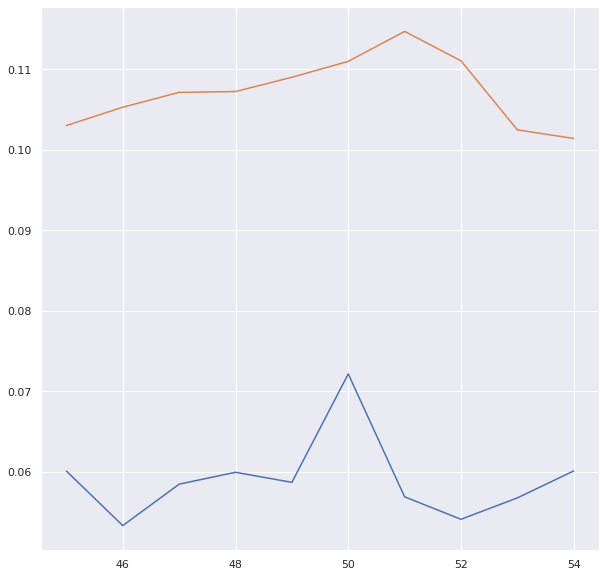

In [ ]:
nn_best_n_comp, nn_best_model_pca, nn_metrics_pca = learn_and_test_rca(MLPClassifier, mlp_best_params, X, Y, range(45, 55))

# Часть №4: Деревья решений

In [ ]:
def learn_and_test_trees(model, params, x_train, y_train, x_test, y_test, trees_range):
  models = []
  general_best_params = []
  general_metrics = []
  metrics_by_trees = {
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': [],
        'trees': trees_range,
        'train_error': [],
        'test_error': [],
        'obb_error': []
    }

  for trees in trees_range:
    params['n_estimators'] = trees
    best_params, learned_model, metrics = learn_and_test_model(model, params, x_train, y_train, x_test, y_test, grid_search = False, verbose = False)
    
    models.append(learned_model)
    general_best_params.append(best_params)
    general_metrics.append(metrics)

    for key in metrics:
      if key in metrics_by_trees:
        metrics_by_trees[key].append(metrics[key])
    
    metrics_by_trees['obb_error'].append(1 - learned_model.oob_score_)
    print("\nLearned model with trees count {}: {}\n".format(trees, metrics))
  
  best_trees =  min((val, idx) for (idx, val) in enumerate(metrics_by_trees['test_error']))
  return general_best_params[best_trees[1]], models[best_trees[1]], general_metrics[best_trees[1]], metrics_by_trees

## 4.1. Random Forest

In [ ]:
params = { 
    'oob_score': True
}

trees_range = list(range(20, 100, 20)) + list(range(100, 500, 50)) + list(range(500, 801, 100))
forest_best_params, forest_learned_model,  forest_model_metrics, metrics_by_trees = learn_and_test_trees(RandomForestClassifier, params, x_train, y_train, x_test, y_test, trees_range)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



Learned model with trees count 20: {'acc': 0.9148323114550876, 'recall': 0.8336313248703737, 'precision': 0.9319408354987008, 'auc': 0.9659338329633087, 'train_error': 0.001775742684833594, 'test_error': 0.08516768854491238}


Learned model with trees count 40: {'acc': 0.9182162361376353, 'recall': 0.843375648131593, 'precision': 0.9319371727748691, 'auc': 0.9698408124450464, 'train_error': 0.00037971856153674335, 'test_error': 0.08178376386236473}


Learned model with trees count 60: {'acc': 0.9191878580761885, 'recall': 0.843375648131593, 'precision': 0.9346146225480484, 'auc': 0.9706584727345601, 'train_error': 6.700915791824883e-05, 'test_error': 0.08081214192381143}


Learned model with trees count 80: {'acc': 0.9187187992093008, 'recall': 0.8435544430538173, 'precision': 0.9331487341772152, 'auc': 0.9712550059296658, 'train_error': 2.233638597274961e-05, 'test_error': 0.08128120079069923}


Learned model with trees count 100: {'acc': 0.9187858076188562, 'recall': 0.8428392633649

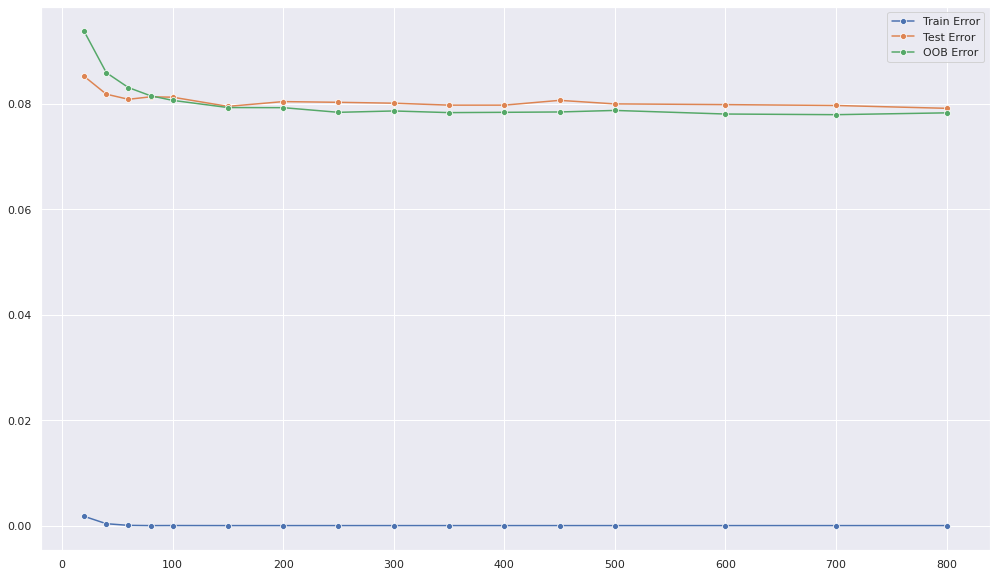

In [ ]:
plt.figure(figsize = (17, 10))
sns.lineplot(x=metrics_by_trees['trees'], y=metrics_by_trees['train_error'],  marker="o", label="Train Error")
sns.lineplot(x=metrics_by_trees['trees'], y=metrics_by_trees['test_error'], marker="o",  label ="Test Error")
sns.lineplot(x=metrics_by_trees['trees'], y= metrics_by_trees['obb_error'],  marker="o",  label="OOB Error")
pass

## 4.2. Градиентный бустинг

In [ ]:
def learn_and_test_gb_trees(model, params, x_train, y_train, x_test, y_test, trees_range):
  models = []
  general_best_params = []
  general_metrics = []
  metrics_by_trees = {
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': [],
        'trees': trees_range,
        'train_error': [],
        'test_error': [],
        'obb_error': []
    }

  for trees in trees_range:
    params['n_estimators'] = trees
    best_params, learned_model, metrics = learn_and_test_model(model, params, x_train, y_train, x_test, y_test, grid_search = False, verbose = False)
    print("\nLearned model with trees count {}: {}\n".format(trees, metrics))
    
    metrics['obb_error'] = np.cumsum(learned_model.oob_improvement_)

    models.append(learned_model)
    general_best_params.append(best_params)
    general_metrics.append(metrics)

    for key in metrics:
      if key in metrics_by_trees:
        metrics_by_trees[key].append(metrics[key])
    
  
  best_trees =  min((val, idx) for (idx, val) in enumerate(metrics_by_trees['test_error']))
  return general_best_params[best_trees[1]], models[best_trees[1]], general_metrics[best_trees[1]], metrics_by_trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

params = { 'subsample': 0.9}

gbt_best_params, gbt_learned_model, gbt_model_metrics, metrics_by_trees = learn_and_test_gb_trees(GradientBoostingClassifier, params, x_train, y_train, x_test, y_test, trees_range)


Learned model with trees count 20: {'acc': 0.7772640466378531, 'recall': 0.4227605935991418, 'precision': 0.9611788617886179, 'auc': 0.8938971829840084, 'train_error': 0.21943265579629215, 'test_error': 0.22273595336214694}


Learned model with trees count 40: {'acc': 0.8423627165209234, 'recall': 0.6699445735741105, 'precision': 0.8809215939814271, 'auc': 0.9179013594134071, 'train_error': 0.1547353138262229, 'test_error': 0.15763728347907663}


Learned model with trees count 60: {'acc': 0.8531510704593427, 'recall': 0.7135705345968174, 'precision': 0.8713022595786486, 'auc': 0.9239713013885575, 'train_error': 0.14566674112128658, 'test_error': 0.14684892954065734}


Learned model with trees count 80: {'acc': 0.8632023318926525, 'recall': 0.7417307348471304, 'precision': 0.8741966073121905, 'auc': 0.9320284960838681, 'train_error': 0.1350234532052714, 'test_error': 0.13679766810734748}


Learned model with trees count 100: {'acc': 0.8660836935035346, 'recall': 0.7420883246915787, 'pr

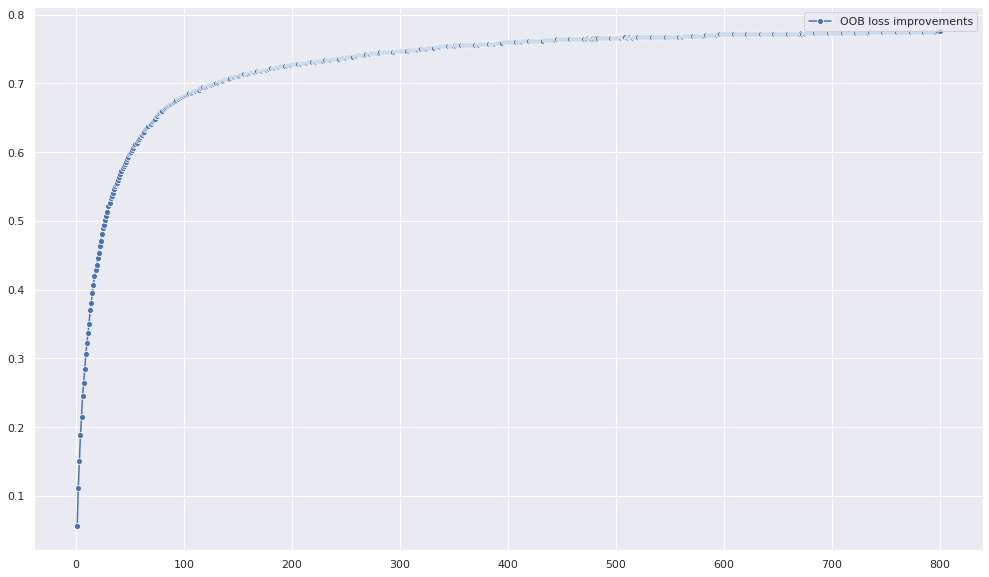

In [ ]:
plt.figure(figsize = (17, 10))
sns.lineplot(x=list(range(1, gbt_model_metrics['obb_error'].size + 1)), y=gbt_model_metrics['obb_error'],  marker="o", label="OOB loss improvements")
pass

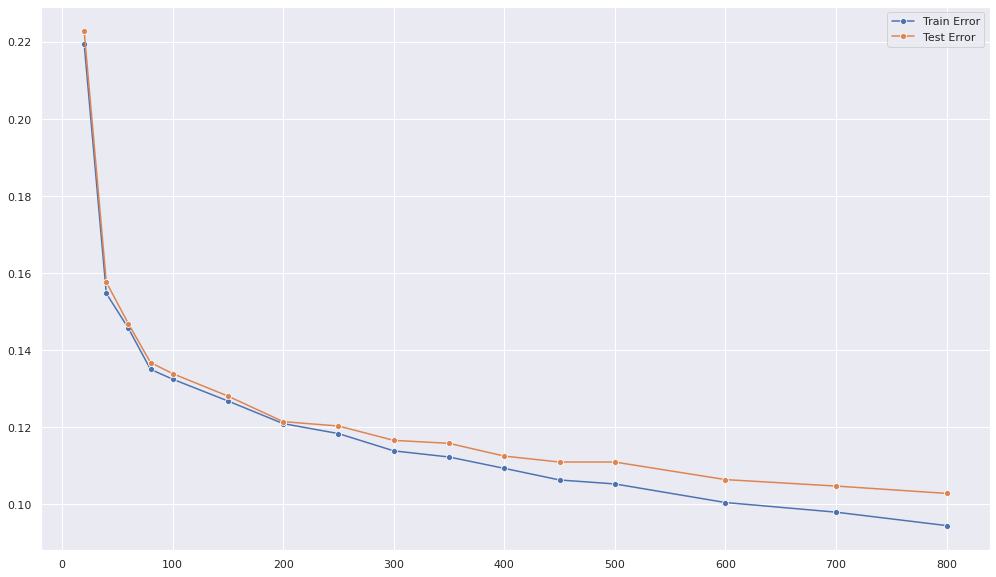

In [ ]:
plt.figure(figsize = (17, 10))
sns.lineplot(x=metrics_by_trees['trees'], y=metrics_by_trees['train_error'],  marker="o", label="Train Error")
sns.lineplot(x=metrics_by_trees['trees'], y=metrics_by_trees['test_error'], marker="o",  label ="Test Error")
pass

## 4.3. Общие выводы

In [ ]:
all_model_metric = [knn_model_metrics, nb_model_metrics, lr_model_metrics, nn_model_metrics, forest_model_metrics, gbt_model_metrics, tree_model_metrics ]
acc= list(map(lambda x: x['acc'], all_model_metric))
recall= list(map(lambda x: x['recall'], all_model_metric))
precision = list(map(lambda x: x['precision'], all_model_metric))
roc_auc = list(map(lambda x: x['auc'], all_model_metric))
train_error = list(map(lambda x: x['train_error'], all_model_metric))
test_error = list(map(lambda x: x['test_error'], all_model_metric))

table = pd.DataFrame({"Model": [ "kNN", "Naive Bayes", "Logistic Regression", "Neural Network", "Random Forest", "Gradient Boosting", "Decision Tree"],
                     "Train Error": train_error,
                     "Test Error": test_error,
                     "Accuracy Scores": acc,
                     "Recall Scores": recall,
                     "Precision Scores": precision,
                     "ROC | Auc": roc_auc})


table["Model"] = table["Model"].astype("category")
table["Train Error"] = table["Train Error"].astype("float32")
table["Test Error"] = table["Test Error"].astype("float32")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")
table["Recall Scores"] = table["Accuracy Scores"].astype("float32")
table["Precision Scores"] = table["Accuracy Scores"].astype("float32")
table["ROC | Auc"] = table["ROC | Auc"].astype("float32")

pd.pivot_table(table, index = ["Model"]).sort_values(by = 'Test Error', ascending=True)

,Accuracy Scores,Precision Scores,ROC | Auc,Recall Scores,Test Error,Train Error
Model,,,,,,
Random Forest,0.920897,0.920897,0.972602,0.920897,0.079103,0.000022
Gradient Boosting,0.897176,0.897176,0.959485,0.897176,0.102824,0.094472
Neural Network,0.893993,0.893993,0.951725,0.893993,0.106007,0.069310
Decision Tree,0.871813,0.871813,0.934296,0.871813,0.128187,0.104657
kNN,0.868865,0.868865,0.912523,0.868865,0.131135,0.068327
Logistic Regression,0.834925,0.834925,0.897127,0.834925,0.165075,0.165260
Naive Bayes,0.746675,0.746675,0.782379,0.746675,0.253325,0.248615


Итак, сделаем выводы по результатом обучения моделей:
 

# Часть №5: Кластеризация

Измеряемые метрики:
* **Однородность** - результат кластеризации является однородным, если все его кластеры содержат только точки данных, которые являются членами одного класса.
* **Полнота** -  результат кластеризации является полным, если все точки данных, которые являются членами данного класса, являются элементами одного и того же кластера.
* **V - мера** - среднее гармоническое между полнотой и однородностью.
* **Silhouette Coefficient** - рассчитывается с использованием среднего внутрикластерного расстояния и среднего расстояния до ближайшего кластера для каждой точки. *Лучшее значение - 1, а худшее - -1. Значения около 0 указывают на перекрывающиеся кластеры. Отрицательные значения обычно указывают на то, что образец был назначен не тому кластеру, поскольку другой кластер более похож.*
* **Ошибка** - обычная ошибка.


## 5.1. K-means

In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=4)

### 5.1.1. Двумерный случай

In [44]:
def visualize_clusterization_result(data, y_kmeans, centroids, h = .02):
  x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
  y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.figure(figsize = (17, 10))
  plt.clf()
  plt.imshow(Z, interpolation="nearest",
             extent=(xx.min(), xx.max(), yy.min(), yy.max()),
             cmap=plt.cm.Pastel1, aspect="auto", origin="lower")

  plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=25, cmap=plt.cm.rainbow)
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
              color="w", zorder=10)

  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [45]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans.fit(reduced_data)

y_kmeans = kmeans.predict(reduced_data)
centroids = kmeans.cluster_centers_

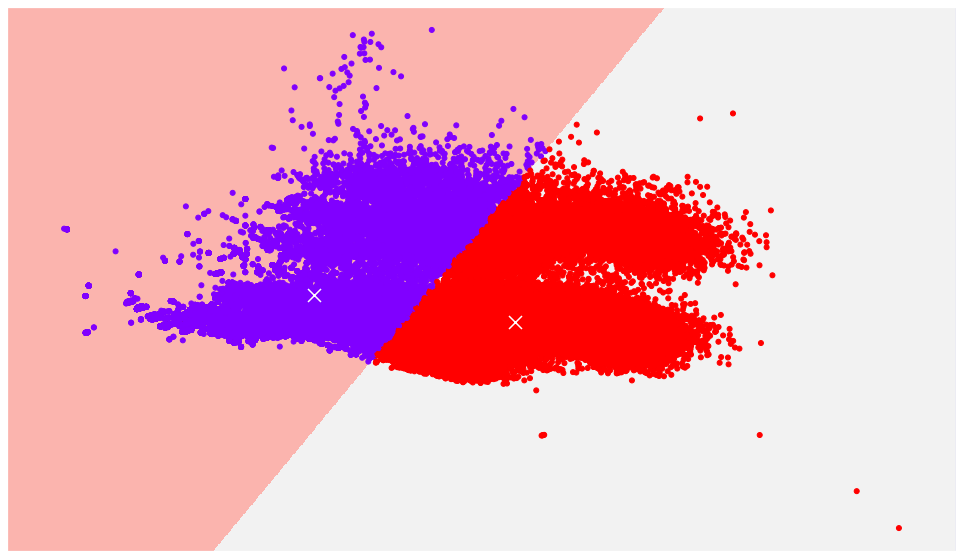

In [46]:
visualize_clusterization_result(reduced_data, y_kmeans,centroids)

### 5.1.2. Общий случай

In [38]:
def clusterization_with_metrics(estimator, name, data, labels):
    estimator = estimator.fit(data)
    results = [name]

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score
    ]

    results += [m(labels, estimator.labels_) for m in clustering_metrics]

    results += [
        metrics.silhouette_score(data, estimator.labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    estimator.labels_[estimator.labels_==-1] = 0
    results +=  [sum(labels == estimator.labels_)/len(labels)]
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t\t{:.7f}")
    print(formatter_result.format(*results))

In [48]:
print(82 * '_')
print('name\t\thomo\tcompl\tv-meas\tsilhouette\terror')
kmeans = KMeans(n_clusters=n_clusters, n_init=4)
clusterization_with_metrics(kmeans, "K-means", X, Y)
print(82 * '_')

__________________________________________________________________________________
name		homo	compl	v-meas	silhouette	error
K-means  	0.010	0.011	0.010	0.144		0.5020731
__________________________________________________________________________________


## 5.2. DBSCAN

In [49]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=2)

In [50]:
print(82 * '_')
print('name\t\thomo\tcompl\tv-meas\tsilhouette\terror')
clusterization_with_metrics(db, "DBSCAN", X, Y)
print(82 * '_')

__________________________________________________________________________________
name		homo	compl	v-meas	silhouette	error
DBSCAN   	0.494	0.066	0.116	-0.276		0.3814737
__________________________________________________________________________________


## 5.3. Mean Shift

In [51]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

In [52]:
print(82 * '_')
print('name\t\thomo\tcompl\tv-meas\tsilhouette\terror')
clusterization_with_metrics(ms, "MeanShift", X, Y)
print(82 * '_')

__________________________________________________________________________________
name		homo	compl	v-meas	silhouette	error
MeanShift	0.015	0.015	0.015	0.319		0.5603374
__________________________________________________________________________________


## 5.4. OPTICS

In [53]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=2,  xi=0.05)

In [54]:
print(82 * '_')
print('name\t\thomo\tcompl\tv-meas\tsilhouette\terror')
clusterization_with_metrics(optics, "OPTICS", X, Y)
print(82 * '_')

__________________________________________________________________________________
name		homo	compl	v-meas	silhouette	error


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS   	0.679	0.055	0.102	-0.142		0.1687118
__________________________________________________________________________________


## 5.6. Выводы

Методы кластеризации плохо справляются с исходной задачей (разбиения датасета на 2 класса). Точность лишь одного из них едва приблизилась к точности наихудшего классификатора